**SEALM: Semantically Enriched Attributes with Language Models for Linkage Recommendation**

# Libraries

In [ ]:
import IPython
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
import itertools
import os
import torch
#import torchtext; #requires downgrading torch
#pip install torch==2.2.2
#pip install torchtext==0.17.2
import tensorflow as tf
import tensorflow.keras as k
import tf_keras
import sklearn
import sklearn.decomposition
import math
import time

In [ ]:
from itertools import combinations
from collections import Counter
from collections import defaultdict
from numpy import trapz
from scipy import spatial, stats
from scipy.integrate import simpson
from scipy.interpolate import splrep, BSpline
from scipy.ndimage import uniform_filter1d
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.cluster import SpectralClustering
from sklearn.metrics import accuracy_score, precision_score, recall_score, auc
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import LocalOutlierFactor
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras import layers, losses
from tensorflow.keras.models import Model
from tqdm.autonotebook import tqdm, trange

In [8]:
import wordninja
from sentence_transformers import SentenceTransformer, util

# OC3 and OC3-HR Schemas

In [3]:
def nan_to_string(x):
  if isinstance(x, float):
    x = str(x)
  return x

In [4]:
#Local Python
df_graph_OC3HRFA = pd.read_csv("C:/Users/leona/Meine Ablage/WS24_25/Metadata Enrichment/df_OC3HRFA_Enrichment.csv")
df_graph_OC3HR = df_graph_OC3HRFA[df_graph_OC3HRFA.schema != "pFA-POSTGRES"].reset_index(drop=True).copy() #df_graph
df_graph_OC3 = df_graph_OC3HRFA[(df_graph_OC3HRFA.schema != "HR-ORACLE") &
                                (df_graph_OC3HRFA.schema != "pFA-POSTGRES")].reset_index(drop=True).copy()

In [5]:
df_graph_OC3HRFA.head(3)

,id,node_type,parent_id,schema,name,refined_name,parent_name,parent_child_name,datatype,constraints,...,promt_v4_time,promt_v6_oLLAMA31,promt_v6_time,domain,v1,v2,v3,v4,v5,v6
0,entity_0,source,NaN,HR-ORACLE,NaN,NaN,NaN,,NaN,NaN,...,0.000000,NaN,0.000000,Human-Resources,NaN,NaN,NaN,NaN,NaN,NaN
1,entity_1,parent,entity_0,HR-ORACLE,COUNTRIES,COUNTRIES,NaN,COUNTRIES,NaN,NaN,...,33.653761,The `COUNTRIES` table is a database table that...,60.069289,Human-Resources,NaN,NaN,NaN,NaN,NaN,NaN
2,entity_2,child,entity_1,HR-ORACLE,COUNTRY_ID,COUNTRY ID,COUNTRIES,COUNTRIES COUNTRY ID,STRING,PRIMARY KEY,...,62.296316,"In the 'Human-Resources' database schema, the ...",138.221250,Human-Resources,COUNTRY ID COUNTRIES,COUNTRY ID COUNTRIES STRING PRIMARY KEY,"COUNTRY ID COUNTRIES STRING PRIMARY KEY CH, DE...",COUNTRY ID COUNTRIES Human-Resources,"COUNTRY ID COUNTRIES CH, DE, ML, JP, KW Human-...","COUNTRY ID COUNTRIES STRING PRIMARY KEY CH, DE..."


In [7]:
#df_graph_OC3HRFA.to_csv("C:/Users/leona/Meine Ablage/WS24_25/Metadata Enrichment/df_OC3HRFA_Enrichment.csv", index=False, encoding='utf-8-sig')

In [6]:
df_OC3HR_gt = pd.read_csv(r'C:/Users/leona/Meine Ablage/SS24 PhD/SeMAI/Ground-Truth/OC3HR-gt.csv')
df_OC3_gt = pd.read_csv(r'C:/Users/leona/Meine Ablage/SS24 PhD/SeMAI/Ground-Truth/OC3-gt.csv')
#df_OC3_HR_FA -> is df_OC3_HR_gt as no linkages with FA

In [7]:
set_OC3_gt = []
set_OC3HR_gt = []

for index, row in df_OC3_gt[(df_OC3_gt.relation_type != "intra_joined") & (df_OC3_gt.type == "Child")].iterrows():
    set_OC3_gt.append((row.entity_a_id, row.entity_b_id))

for index, row in df_OC3HR_gt[(df_OC3HR_gt.relation_type != "intra_joined") & (df_OC3HR_gt.type == "Child")].iterrows():
    set_OC3HR_gt.append((row.entity_a_id, row.entity_b_id))

# SOTA Baseline: Entity Descriptions (v1,v2,..,v6)

In [46]:
df_graph_OC3HRFA.name = df_graph_OC3HRFA.name.fillna('')
df_graph_OC3HRFA.refined_name = df_graph_OC3HRFA.refined_name.fillna('')
df_graph_OC3HRFA.parent_name = df_graph_OC3HRFA.parent_name.fillna('')
df_graph_OC3HRFA.instances = df_graph_OC3HRFA.instances.fillna('')
df_graph_OC3HRFA.datatype = df_graph_OC3HRFA.datatype.fillna('')
df_graph_OC3HRFA.constraints = df_graph_OC3HRFA.constraints.fillna('')
# df_graph_OC3HRFA.loc[df_graph_OC3HRFA.name == 'nan', 'name'] = ""

In [47]:
#check whether wronlgy formatted attributes exist in dataframe
for i, instance in enumerate(df_graph_OC3HRFA.instances.values):
  if isinstance(instance, float):
    print(i)
    print(instance)
    print(str(instance))

In [48]:
df_graph_OC3HRFA.head(3)

,id,node_type,parent_id,schema,name,refined_name,parent_name,parent_child_name,datatype,constraints,...,promt_v5_time,promt_v6_oLLAMA31,promt_v6_time,domain,v1,v2,v3,v4,v5,v6
0,entity_0,source,NaN,HR-ORACLE,,,,,,,...,0.000000,NaN,0.000000,Human-Resources,NaN,NaN,NaN,NaN,NaN,NaN
1,entity_1,parent,entity_0,HR-ORACLE,COUNTRIES,COUNTRIES,,COUNTRIES,,,...,33.653761,The `COUNTRIES` table is a database table that...,60.069289,Human-Resources,NaN,NaN,NaN,NaN,NaN,NaN
2,entity_2,child,entity_1,HR-ORACLE,COUNTRY_ID,COUNTRY ID,COUNTRIES,COUNTRIES COUNTRY ID,STRING,PRIMARY KEY,...,62.296316,"In the 'Human-Resources' database schema, the ...",138.221250,Human-Resources,COUNTRY ID COUNTRIES,COUNTRY ID COUNTRIES STRING PRIMARY KEY,"COUNTRY ID COUNTRIES STRING PRIMARY KEY CH, DE...","COUNTRY ID COUNTRIES CH, DE, ML, JP, KW Human-...",COUNTRY ID COUNTRIES Human-Resources,"COUNTRY ID COUNTRIES STRING PRIMARY KEY CH, DE..."


In [49]:
def set_domain(schema):
    if("OC" in str(schema)):
        return 'Order-Customers'
    if("HR" in str(schema)):
        return 'Human-Resources'
    if("FA" in str(schema)):
        return 'Film-Artists'

In [50]:
df_graph_OC3HRFA["domain"] = df_graph_OC3HRFA.schema.apply(lambda entity: set_domain(entity))
df_graph_OC3HRFA["v1"] = df_graph_OC3HRFA["refined_name"] + " " + df_graph_OC3HRFA["parent_name"]
df_graph_OC3HRFA["v2"] = df_graph_OC3HRFA["v1"] + " " + df_graph_OC3HRFA["datatype"] + " " + df_graph_OC3HRFA["constraints"]
df_graph_OC3HRFA["v3"] = df_graph_OC3HRFA["v2"] + " " + df_graph_OC3HRFA["instances"]
df_graph_OC3HRFA["v4"] = df_graph_OC3HRFA["v1"] + " " + df_graph_OC3HRFA["domain"]
df_graph_OC3HRFA["v5"] = df_graph_OC3HRFA["v1"] + " " + df_graph_OC3HRFA["instances"] + " " + df_graph_OC3HRFA["domain"]
df_graph_OC3HRFA["v6"] = df_graph_OC3HRFA["v3"] + " " + df_graph_OC3HRFA["domain"]

In [51]:
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'source','v1'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'source','v2'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'source','v3'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'source','v4'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'source','v5'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'source','v6'] = np.nan

df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'parent','v1'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'parent','v2'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'parent','v3'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'parent','v4'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'parent','v5'] = np.nan
df_graph_OC3HRFA.loc[df_graph_OC3HRFA['node_type'] == 'parent','v6'] = np.nan

# SEALM

## Promt Engineering (promt_v1, promt_v2, ..., promt_v6)

In [53]:
def promt(entity, version):
  	
  promt = "Briefly describe the"

  #Attribute Building Blocks
  attribute_name = " attribute '" + str(entity["refined_name"]) + "'"
  attribute_parent_name = " stored in the table '" + str(entity["parent_name"]) + "'"

  attribute_data_type = " with the data type '" + str(entity["datatype"]) + "'" 
  
  if(str(entity.constraints) != "nan"):
    attribute_constraint = " and the constraint '" + str(entity["constraints"]) + "'"
  else:
    attribute_constraint = ""

  if(str(entity.instances) != "nan"):
    attribute_instances = " with sampled instances [" + str(entity.instances) + "]"
  else:
    attribute_instances = ""
  
  if("OC" in str(entity.schema)):
    attribute_context = " in the context of a 'Order-Customers' database schema and how it might be used"
  if("HR" in str(entity.schema)):
    attribute_context = " in the context of a 'Human-Resources' database schema and how it might be used"
  if("FA" in str(entity.schema)):
    attribute_context = " in the context of a 'Film-Artists' database schema and how it might be used"
  
  #Promt Construction
  if(entity.node_type == "source"):
    return ""
  
  #promt_v1
  if(version == "promt_v1"):
    if(entity.node_type == "parent"):
      promt = promt + " table " + str(entity["refined_name"]) + "' with the attributes [" + str(entity.instances) + "]"
    if(entity.node_type == "child"):
      promt = promt + attribute_name + attribute_parent_name

  #promt_v2
  if(version == "promt_v2"):
    if(entity.node_type == "parent"):
      promt = promt + " table " + str(entity["refined_name"]) + "' with the attributes [" + str(entity.instances) + "]"
    if(entity.node_type == "child"):
      promt = promt + attribute_name + attribute_parent_name + attribute_data_type + attribute_constraint 

  #promt_v3
  if(version == "promt_v3"):
    if(entity.node_type == "parent"):
      promt = promt + " table " + str(entity["refined_name"]) + "' with the attributes [" + str(entity.instances) + "]"
    if(entity.node_type == "child"):
      promt = promt + attribute_name + attribute_parent_name + attribute_data_type + attribute_constraint + attribute_instances
  
  #promt_v4
  if(version == "promt_v4"):
    if(entity.node_type == "parent"):
      promt = promt + " table " + str(entity["refined_name"]) + "' with the attributes [" + str(entity.instances) + "]"
    if(entity.node_type == "child"):
      promt = promt + attribute_name + attribute_parent_name + attribute_context

  #promt_v5
  if(version == "promt_v5"):
    if(entity.node_type == "parent"):
      promt = promt + " table " + str(entity["refined_name"]) + "' with the attributes [" + str(entity.instances) + "]"
    if(entity.node_type == "child"):
      promt = promt + attribute_name + attribute_parent_name + attribute_instances + attribute_context

  #promt_v6
  if(version == "promt_v6"):
    if(entity.node_type == "parent"):
      promt = promt + " table " + str(entity["refined_name"]) + "' with the attributes [" + str(entity.instances) + "]"
    if(entity.node_type == "child"):
      promt = promt + attribute_name + attribute_parent_name + attribute_data_type + attribute_constraint + attribute_instances + attribute_context

  return promt + "."

In [54]:
df_graph_OC3HRFA["promt_v1"] = df_graph_OC3HRFA.apply(lambda x: promt(x, "promt_v1"), axis=1)
df_graph_OC3HRFA["promt_v2"] = df_graph_OC3HRFA.apply(lambda x: promt(x, "promt_v2"), axis=1)
df_graph_OC3HRFA["promt_v3"] = df_graph_OC3HRFA.apply(lambda x: promt(x, "promt_v3"), axis=1)
df_graph_OC3HRFA["promt_v4"] = df_graph_OC3HRFA.apply(lambda x: promt(x, "promt_v4"), axis=1)
df_graph_OC3HRFA["promt_v5"] = df_graph_OC3HRFA.apply(lambda x: promt(x, "promt_v5"), axis=1)
df_graph_OC3HRFA["promt_v6"] = df_graph_OC3HRFA.apply(lambda x: promt(x, "promt_v6"), axis=1)

In [55]:
print(df_graph_OC3HRFA.promt_v1[2])
print(df_graph_OC3HRFA.promt_v2[2])
print(df_graph_OC3HRFA.promt_v3[2])
print(df_graph_OC3HRFA.promt_v4[2])
print(df_graph_OC3HRFA.promt_v5[2])
print(df_graph_OC3HRFA.promt_v6[2])

Briefly describe the attribute 'COUNTRY ID' stored in the table 'COUNTRIES'.
Briefly describe the attribute 'COUNTRY ID' stored in the table 'COUNTRIES' with the data type 'STRING' and the constraint 'PRIMARY KEY'.
Briefly describe the attribute 'COUNTRY ID' stored in the table 'COUNTRIES' with the data type 'STRING' and the constraint 'PRIMARY KEY' with sampled instances [CH, DE, ML, JP, KW].
Briefly describe the attribute 'COUNTRY ID' stored in the table 'COUNTRIES' in the context of a 'Human-Resources' database schema and how it might be used.
Briefly describe the attribute 'COUNTRY ID' stored in the table 'COUNTRIES' with sampled instances [CH, DE, ML, JP, KW] in the context of a 'Human-Resources' database schema and how it might be used.
Briefly describe the attribute 'COUNTRY ID' stored in the table 'COUNTRIES' with the data type 'STRING' and the constraint 'PRIMARY KEY' with sampled instances [CH, DE, ML, JP, KW] in the context of a 'Human-Resources' database schema and how it m

In [56]:
print(df_graph_OC3HRFA.promt_v1[3])
print(df_graph_OC3HRFA.promt_v2[3])
print(df_graph_OC3HRFA.promt_v3[3])
print(df_graph_OC3HRFA.promt_v4[3])
print(df_graph_OC3HRFA.promt_v5[3])
print(df_graph_OC3HRFA.promt_v6[3])

Briefly describe the attribute 'COUNTRY NAME' stored in the table 'COUNTRIES'.
Briefly describe the attribute 'COUNTRY NAME' stored in the table 'COUNTRIES' with the data type 'STRING' and the constraint ''.
Briefly describe the attribute 'COUNTRY NAME' stored in the table 'COUNTRIES' with the data type 'STRING' and the constraint '' with sampled instances [Nigeria, India, Italy, Belgium, Brazil].
Briefly describe the attribute 'COUNTRY NAME' stored in the table 'COUNTRIES' in the context of a 'Human-Resources' database schema and how it might be used.
Briefly describe the attribute 'COUNTRY NAME' stored in the table 'COUNTRIES' with sampled instances [Nigeria, India, Italy, Belgium, Brazil] in the context of a 'Human-Resources' database schema and how it might be used.
Briefly describe the attribute 'COUNTRY NAME' stored in the table 'COUNTRIES' with the data type 'STRING' and the constraint '' with sampled instances [Nigeria, India, Italy, Belgium, Brazil] in the context of a 'Human-

In [58]:
print(df_graph_OC3HRFA.promt_v1[8])
print(df_graph_OC3HRFA.promt_v2[8])
print(df_graph_OC3HRFA.promt_v3[8])
print(df_graph_OC3HRFA.promt_v4[8])
print(df_graph_OC3HRFA.promt_v5[8])
print(df_graph_OC3HRFA.promt_v6[8])

Briefly describe the attribute 'MANAGER ID' stored in the table 'DEPARTMENTS'.
Briefly describe the attribute 'MANAGER ID' stored in the table 'DEPARTMENTS' with the data type 'INTEGER' and the constraint 'FOREIGN KEY'.
Briefly describe the attribute 'MANAGER ID' stored in the table 'DEPARTMENTS' with the data type 'INTEGER' and the constraint 'FOREIGN KEY' with sampled instances [108, 100, 201, 205, 203].
Briefly describe the attribute 'MANAGER ID' stored in the table 'DEPARTMENTS' in the context of a 'Human-Resources' database schema and how it might be used.
Briefly describe the attribute 'MANAGER ID' stored in the table 'DEPARTMENTS' with sampled instances [108, 100, 201, 205, 203] in the context of a 'Human-Resources' database schema and how it might be used.
Briefly describe the attribute 'MANAGER ID' stored in the table 'DEPARTMENTS' with the data type 'INTEGER' and the constraint 'FOREIGN KEY' with sampled instances [108, 100, 201, 205, 203] in the context of a 'Human-Resources

In [59]:
print(df_graph_OC3HRFA.promt_v1[71])
print(df_graph_OC3HRFA.promt_v2[71])
print(df_graph_OC3HRFA.promt_v3[71])
print(df_graph_OC3HRFA.promt_v4[71])
print(df_graph_OC3HRFA.promt_v5[71])
print(df_graph_OC3HRFA.promt_v6[71])

Briefly describe the attribute 'PRODUCT IMAGE' stored in the table 'PRODUCTS'.
Briefly describe the attribute 'PRODUCT IMAGE' stored in the table 'PRODUCTS' with the data type 'BLOB' and the constraint ''.
Briefly describe the attribute 'PRODUCT IMAGE' stored in the table 'PRODUCTS' with the data type 'BLOB' and the constraint '' with sampled instances [(BLOB)].
Briefly describe the attribute 'PRODUCT IMAGE' stored in the table 'PRODUCTS' in the context of a 'Order-Customers' database schema and how it might be used.
Briefly describe the attribute 'PRODUCT IMAGE' stored in the table 'PRODUCTS' with sampled instances [(BLOB)] in the context of a 'Order-Customers' database schema and how it might be used.
Briefly describe the attribute 'PRODUCT IMAGE' stored in the table 'PRODUCTS' with the data type 'BLOB' and the constraint '' with sampled instances [(BLOB)] in the context of a 'Order-Customers' database schema and how it might be used.


## GLM Invoke with oLLAMA

In [ ]:
#shell comands (based on https://medium.com/@renjuhere/llama-3-running-locally-in-just-2-steps-e7c63216abe7)

#check http server running: http://localhost:11434/
#storage of models under “C:\Users\<username>\.ollama\models”.

#ollama run llama3 > rund model (will be downloaded if not stored yet; default 8B; pre-trained would be ~ ollama run llama3:text)
#ollama list > find the available local models
#ollama pull llama3 > upgrade delta layers
#ollama rm llama3 > remove model

# C:\Users\leona>ollama list
# NAME            ID              SIZE    MODIFIED
# llama3:text     870a5d02cfaf    4.7 GB  4 weeks ago
# llama3:latest   365c0bd3c000    4.7 GB  4 weeks ago


#promt in cmd
#/bye > exit conversation


In [ ]:
#pip install transformers
#pip install accelerate
#pip install llama-models
#import transformers
#pip install langchain-community

In [202]:
from langchain_community.llms import Ollama

In [290]:
llm = Ollama(model="llama3")

In [204]:
instruction_prompt = "Your task is to describe attributes from heterogeneous relational databases based on extracted schema metadata to improve Entity Linkage for Data Integration."

for chunks in llm.stream(instruction_prompt):
    print(chunks, end="")

A very specific and technical question!

To answer this, let me break it down step by step:

**Task:** Describe attributes from heterogeneous relational databases based on extracted schema metadata to improve Entity Linkage for Data Integration.

**Background:**

* **Heterogeneous Relational Databases**: A collection of different relational databases (e.g., MySQL, Oracle, PostgreSQL) that store data in various formats and structures.
* **Schema Metadata**: The descriptive information about the database's structure, including table names, column names, data types, relationships between tables, etc.
* **Entity Linkage**: The process of identifying and connecting entities (e.g., people, organizations, locations) across multiple databases or sources to create a unified view of the data.

**Description of Attributes:**

To improve entity linkage for data integration, we need to extract and describe attributes from heterogeneous relational databases based on their schema metadata. Here are s

In [205]:
def get_answer(id, node_type, promt):
    start_time = time.time()
    
    if node_type == "source":
        answer = None
    else:
        answer = llm.invoke(promt) 
    
    end_time = time.time()
    elapsed_time = end_time - start_time
    print(id)
    #print(id, str(elapsed_time))
    return answer, elapsed_time

## v1

In [196]:
df_graph_OC3HRFA[['promt_v1_oLLAMA31', 'promt_v1_time']] = df_graph_OC3HRFA.apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v1'])), axis=1)

entity_0
entity_1
entity_2
entity_3
entity_4
entity_5
entity_6
entity_7
entity_8
entity_9
entity_10
entity_11
entity_12
entity_13
entity_14
entity_15
entity_16
entity_17
entity_18
entity_19
entity_20
entity_21
entity_22
entity_23
entity_24
entity_25
entity_26
entity_27
entity_28
entity_29
entity_30
entity_31
entity_32
entity_33
entity_34
entity_35
entity_36
entity_37
entity_38
entity_39
entity_40
entity_41
entity_42
entity_43
entity_44
entity_45
entity_46
entity_47
entity_48
entity_49
entity_50
entity_51
entity_52
entity_53
entity_54
entity_55
entity_56
entity_57
entity_58
entity_59
entity_60
entity_61
entity_62
entity_63
entity_64
entity_65
entity_66
entity_67
entity_68
entity_69
entity_70
entity_71
entity_72
entity_73
entity_74
entity_75
entity_76
entity_77
entity_78
entity_79
entity_80
entity_81
entity_82
entity_83
entity_84
entity_85
entity_86
entity_87
entity_88
entity_89
entity_90
entity_91
entity_92
entity_93
entity_94
entity_95
entity_96
entity_97
entity_98
entity_99
entity_100

In [62]:
df_graph_OC3HRFA.promt_v1_time.mean()

70.475672842438

## v2

In [15]:
df_graph_OC3HRFA[['promt_v2_oLLAMA31', 'promt_v2_time']] = df_graph_OC3HRFA.apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v2'])), axis=1)

entity_0
entity_1
entity_2
entity_3
entity_4
entity_5
entity_6
entity_7
entity_8
entity_9
entity_10
entity_11
entity_12
entity_13
entity_14
entity_15
entity_16
entity_17
entity_18
entity_19
entity_20
entity_21
entity_22
entity_23
entity_24
entity_25
entity_26
entity_27
entity_28
entity_29
entity_30
entity_31
entity_32
entity_33
entity_34
entity_35
entity_36
entity_37
entity_38
entity_39
entity_40
entity_41
entity_42
entity_43
entity_44
entity_45
entity_46
entity_47
entity_48
entity_49
entity_50
entity_51
entity_52
entity_53
entity_54
entity_55
entity_56
entity_57
entity_58
entity_59
entity_60
entity_61
entity_62
entity_63
entity_64
entity_65
entity_66
entity_67
entity_68
entity_69
entity_70
entity_71
entity_72
entity_73
entity_74
entity_75
entity_76
entity_77
entity_78
entity_79
entity_80
entity_81
entity_82
entity_83
entity_84
entity_85
entity_86
entity_87
entity_88
entity_89
entity_90
entity_91
entity_92
entity_93
entity_94
entity_95
entity_96
entity_97
entity_98
entity_99
entity_100

In [63]:
df_graph_OC3HRFA.promt_v2_time.mean()

52.343939472314055

In [64]:
df_graph_OC3HRFA.head(30).promt_v2_oLLAMA31

0                                                   NaN
1     The `COUNTRIES` table appears to be a database...
2     The "COUNTRY ID" attribute is a unique identif...
3     The attribute "COUNTRY_NAME" is a column in th...
4     The attribute "REGION_ID" in the table "COUNTR...
5     The `DEPARTMENTS` table is a database table th...
6     The "DEPARTMENT ID" attribute, stored in the "...
7     The attribute "DEPARTMENT NAME" stored in the ...
8     The 'MANAGER ID' attribute in the 'DEPARTMENTS...
9     The `LOCATION_ID` attribute in the `DEPARTMENT...
10    The `EMPLOYEES` table is a relational database...
11    The "EMPLOYEE ID" attribute, stored in the "EM...
12    The attribute "FIRST NAME" is a character-base...
13    The attribute "LAST_NAME" stored in the table ...
14    I'm happy to help!\n\nHowever, I must clarify ...
15    I think there may be a mistake here!\n\nIf the...
16    The attribute 'HIRE_DATE' stored in the table ...
17    I think there may be a mistake here!\n\nIn

## v3

In [65]:
df_graph_OC3HRFA[['promt_v3_oLLAMA31', 'promt_v3_time']] = df_graph_OC3HRFA.apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v3'])), axis=1)

entity_0
entity_1
entity_2
entity_3
entity_4
entity_5
entity_6
entity_7
entity_8
entity_9
entity_10
entity_11
entity_12
entity_13
entity_14
entity_15
entity_16
entity_17
entity_18
entity_19
entity_20
entity_21
entity_22
entity_23
entity_24
entity_25
entity_26
entity_27
entity_28
entity_29
entity_30
entity_31
entity_32
entity_33
entity_34
entity_35
entity_36
entity_37
entity_38
entity_39
entity_40
entity_41
entity_42
entity_43
entity_44
entity_45
entity_46
entity_47
entity_48
entity_49
entity_50
entity_51
entity_52
entity_53
entity_54
entity_55
entity_56
entity_57
entity_58
entity_59
entity_60
entity_61
entity_62
entity_63
entity_64
entity_65
entity_66
entity_67
entity_68
entity_69
entity_70
entity_71
entity_72
entity_73
entity_74
entity_75
entity_76
entity_77
entity_78
entity_79
entity_80
entity_81
entity_82
entity_83
entity_84
entity_85
entity_86
entity_87
entity_88
entity_89
entity_90
entity_91
entity_92
entity_93
entity_94
entity_95
entity_96
entity_97
entity_98
entity_99
entity_100

In [67]:
df_graph_OC3HRFA.promt_v3_time.mean()

56.94643031861171

## v4

In [66]:
df_graph_OC3HRFA[['promt_v4_oLLAMA31', 'promt_v4_time']] = df_graph_OC3HRFA.apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v4'])), axis=1)

entity_0
entity_1
entity_2
entity_3
entity_4
entity_5
entity_6
entity_7
entity_8
entity_9
entity_10
entity_11
entity_12
entity_13
entity_14
entity_15
entity_16
entity_17
entity_18
entity_19
entity_20
entity_21
entity_22
entity_23
entity_24
entity_25
entity_26
entity_27
entity_28
entity_29
entity_30
entity_31
entity_32
entity_33
entity_34
entity_35
entity_36
entity_37
entity_38
entity_39
entity_40
entity_41
entity_42
entity_43
entity_44
entity_45
entity_46
entity_47
entity_48
entity_49
entity_50
entity_51
entity_52
entity_53
entity_54
entity_55
entity_56
entity_57
entity_58
entity_59
entity_60
entity_61
entity_62
entity_63
entity_64
entity_65
entity_66
entity_67
entity_68
entity_69
entity_70
entity_71
entity_72
entity_73
entity_74
entity_75
entity_76
entity_77
entity_78
entity_79
entity_80
entity_81
entity_82
entity_83
entity_84
entity_85
entity_86
entity_87
entity_88
entity_89
entity_90
entity_91
entity_92
entity_93
entity_94
entity_95
entity_96
entity_97
entity_98
entity_99
entity_100

In [68]:
df_graph_OC3HRFA.promt_v4_time.mean()

98.88786568424918

## v5

In [69]:
df_graph_OC3HRFA[['promt_v5_oLLAMA31', 'promt_v5_time']] = df_graph_OC3HRFA.apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v5'])), axis=1)

entity_0
entity_1
entity_2
entity_3
entity_4
entity_5
entity_6
entity_7
entity_8
entity_9
entity_10
entity_11
entity_12
entity_13
entity_14
entity_15
entity_16
entity_17
entity_18
entity_19
entity_20
entity_21
entity_22
entity_23
entity_24
entity_25
entity_26
entity_27
entity_28
entity_29
entity_30
entity_31
entity_32
entity_33
entity_34
entity_35
entity_36
entity_37
entity_38
entity_39
entity_40
entity_41
entity_42
entity_43
entity_44
entity_45
entity_46
entity_47
entity_48
entity_49
entity_50
entity_51
entity_52
entity_53
entity_54
entity_55
entity_56
entity_57
entity_58
entity_59
entity_60
entity_61
entity_62
entity_63
entity_64
entity_65
entity_66
entity_67
entity_68
entity_69
entity_70
entity_71
entity_72
entity_73
entity_74
entity_75
entity_76
entity_77
entity_78
entity_79
entity_80
entity_81
entity_82
entity_83
entity_84
entity_85
entity_86
entity_87
entity_88
entity_89
entity_90
entity_91
entity_92
entity_93
entity_94
entity_95
entity_96
entity_97
entity_98
entity_99
entity_100

In [70]:
df_graph_OC3HRFA.promt_v5_time.mean()

87.79389040135155

## v6

In [71]:
df_graph_OC3HRFA[['promt_v6_oLLAMA31', 'promt_v6_time']] = df_graph_OC3HRFA.apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v6'])), axis=1)

entity_0
entity_1
entity_2
entity_3
entity_4
entity_5
entity_6
entity_7
entity_8
entity_9
entity_10
entity_11
entity_12
entity_13
entity_14
entity_15
entity_16
entity_17
entity_18
entity_19
entity_20
entity_21
entity_22
entity_23
entity_24
entity_25
entity_26
entity_27
entity_28
entity_29
entity_30
entity_31
entity_32
entity_33
entity_34
entity_35
entity_36
entity_37
entity_38
entity_39
entity_40
entity_41
entity_42
entity_43
entity_44
entity_45
entity_46
entity_47
entity_48
entity_49
entity_50
entity_51
entity_52
entity_53
entity_54
entity_55
entity_56
entity_57
entity_58
entity_59
entity_60
entity_61
entity_62
entity_63
entity_64
entity_65
entity_66
entity_67
entity_68
entity_69
entity_70
entity_71
entity_72
entity_73
entity_74
entity_75
entity_76
entity_77
entity_78
entity_79
entity_80
entity_81
entity_82
entity_83
entity_84
entity_85
entity_86
entity_87
entity_88
entity_89
entity_90
entity_91
entity_92
entity_93
entity_94
entity_95
entity_96
entity_97
entity_98
entity_99
entity_100

In [72]:
df_graph_OC3HRFA.promt_v6_time.mean()

105.61585287023182

In [73]:
df_graph_OC3HRFA

,id,node_type,parent_id,schema,name,refined_name,parent_name,datatype,constraints,instances,...,promt_v2_oLLAMA31,promt_v2_time,promt_v3_oLLAMA31,promt_v3_time,promt_v4_oLLAMA31,promt_v4_time,promt_v5_oLLAMA31,promt_v5_time,promt_v6_oLLAMA31,promt_v6_time
0,entity_0,source,NaN,HR-ORACLE,nan,NaN,NaN,NaN,NaN,nan,...,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000,NaN,0.000000
1,entity_1,parent,entity_0,HR-ORACLE,COUNTRIES,COUNTRIES,NaN,NaN,NaN,"COUNTRY ID, COUNTRY NAME, REGION ID",...,The `COUNTRIES` table appears to be a database...,52.399757,The `COUNTRIES` table is a database table that...,45.095726,The `COUNTRIES` table has three attributes:\n\...,39.109574,The `COUNTRIES` table has three attributes:\n\...,33.653761,The `COUNTRIES` table is a database table that...,60.069289
2,entity_2,child,entity_1,HR-ORACLE,COUNTRY_ID,COUNTRY ID,COUNTRIES,STRING,PRIMARY KEY,"CH, DE, ML, JP, KW",...,"The ""COUNTRY ID"" attribute is a unique identif...",43.670309,"The ""COUNTRY ID"" attribute is a column in the ...",41.634681,In the context of a 'Human-Resources' database...,110.057472,In the context of a 'Human-Resources' database...,62.296316,"In the 'Human-Resources' database schema, the ...",138.221250
3,entity_3,child,entity_1,HR-ORACLE,COUNTRY_NAME,COUNTRY NAME,COUNTRIES,STRING,NaN,"Nigeria, India, Italy, Belgium, Brazil",...,"The attribute ""COUNTRY_NAME"" is a column in th...",26.083104,"The ""COUNTRY NAME"" attribute is a column in th...",31.660575,"In the context of a ""Human-Resources"" database...",115.481993,"In the context of a ""Human-Resources"" database...",101.755544,"In the 'Human-Resources' database schema, the ...",129.813140
4,entity_4,child,entity_1,HR-ORACLE,REGION_ID,REGION ID,COUNTRIES,INTEGER,FOREIGN KEY,2,...,"The attribute ""REGION_ID"" in the table ""COUNTR...",50.657782,"Based on your description, I can provide a bri...",59.256701,"In the context of a ""Human-Resources"" database...",116.843672,"In the 'Human-Resources' database schema, the ...",95.423477,"In the 'Human-Resources' database schema, the ...",108.018215
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
237,entity_237,child,entity_228,pFA-POSTGRES,replacement_cost,REPLACEMENT COST,FILM,FLOAT,NaN,"9.99, 16.99, 18.99, 12.99, 26.99",...,"I'm happy to help!\n\nHowever, I must clarify ...",93.378490,The `REPLACEMENT_COST` attribute in the `FILM`...,100.785315,In the 'FILM' table within the 'Film-Artists' ...,78.314255,"In the 'Film-Artists' database schema, the 'RE...",98.678065,In the 'FILM' table of the 'Film-Artists' data...,152.368842
238,entity_238,child,entity_228,pFA-POSTGRES,rating,RATING,FILM,STRING,NaN,"PG, R, NC-17, PG-13, G",...,I think there may be a mistake here!\n\nIf `RA...,60.299857,The `RATING` attribute is a column in the `FIL...,60.973487,In the context of a 'Film-Artists' database sc...,104.512072,In the context of a 'Film-Artists' database sc...,83.324456,In the context of the 'Film-Artists' database ...,110.667414
239,entity_239,child,entity_228,pFA-POSTGRES,last_update,LAST UPDATE,FILM,DATE,NaN,12:20.5,...,"The ""LAST UPDATE"" attribute is a column stored...",27.701957,The attribute 'LAST UPDATE' is a column in the...,39.989672,In the context of a 'Film-Artists' database sc...,77.245448,In the context of a 'Film-Artists' database sc...,88.273243,"In the Film-Artists database, the attribute ""L...",81.677353
240,entity_240,child,entity_228,pFA-POSTGRES,special_features,SPECIAL FEATURES,FILM,STRING,NaN,"{Trailers&Commentaries&Deleted Scenes}, {Trail...",...,"The ""SPECIAL FEATURES"" attribute stored in the...",42.771654,"The ""SPECIAL FEATURES"" attribute in the ""FILM""...",88.003894,In the 'FILM' table of the 'Film-Artists' data...,90.456848,In the context of a 'Film-Artists' database sc...,109.325928,"In the context of a ""Film-Artists"" database sc...",115.010778


## Outliers in SEALM Invoke

In [213]:
entity_ids_repromt = ["entity_13"]
#entity_ids_repromt = ["entity_10", "entity_11"]

In [214]:
df_repromt_v1 = df_graph_OC3HRFA[df_graph_OC3HRFA["id"].isin(entity_ids_repromt)].apply(
    lambda entity: pd.Series(get_answer(entity['id'], entity['node_type'], entity['promt_v1'])), axis=1)

entity_13


In [215]:
df_repromt_v1

,0,1
9,"I'm happy to help!\n\nHowever, I must clarify ...",202.30095


In [216]:
#df_repromt_v1.to_csv("C:/Users/leona/Meine Ablage/WS24_25/Metadata Enrichment/df_repromt_v1.csv", index=False, encoding='utf-8-sig')

# Signature + Processing Time

In [20]:
class Entity:
    def __init__(
        self, entity_id, refined_name, node_type, schema, parent_id, parent_child_name,
        v1=0, v2=0, v3=0, v4=0, v5=0, v6=0, 
        promt_v1=0, promt_v2=0, promt_v3=0, promt_v4=0, promt_v5=0, promt_v6=0
    ):
        self.entity_id = entity_id
        self.refined_name = refined_name
        self.node_type = node_type
        self.schema = schema
        self.parent_id = parent_id
        self.parent_child_name = parent_child_name
        self.v1 = v1
        self.v2 = v2
        self.v3 = v3
        self.v4 = v4
        self.v5 = v5
        self.v6 = v6
        self.promt_v1 = promt_v1
        self.promt_v2 = promt_v2
        self.promt_v3 = promt_v3
        self.promt_v4 = promt_v4
        self.promt_v5 = promt_v5
        self.promt_v6 = promt_v6

    def __repr__(self):
        return (
            f"Entity({self.entity_id}, {self.refined_name}, {self.node_type}, "
            f"{self.schema}, {self.parent_id}, {self.parent_child_name}, {self.structure}"
            f"{self.v1_child_name})"
        )

In [21]:
def get_entity_signatures(entities, variant):
    ''' former concept_embeddings_to_ce_x'''
    entity_signatures = []
    for entity in entities:
        value = getattr(entity, variant)
        if isinstance(value, np.ndarray):
            entity_signatures.append(value)
        elif isinstance(value, str):
            entity_signatures.append(value)
        else:
            # Assuming tensor-like object that needs conversion to numpy
            try:
                entity_signatures.append(value.numpy())
            except AttributeError:
                entity_signatures.append(value)  # In case it's already a number or not convertible
    return np.array(entity_signatures)

In [22]:
def normalize_entity_signatures(entities, attribute_variant):
  scaler = MinMaxScaler(feature_range = (0,1))
  entity_signatures_normalized = scaler.fit_transform(get_entity_signatures(entities, attribute_variant)) #"ce_description"

  for i, entity in enumerate(entities):
    setattr(entity, attribute_variant+"_normalized", entity_signatures_normalized[i])

In [23]:
def get_entities_from_df(df_graph, model_name='sentence-transformers/gtr-t5-base'):
  entities = []
  
  model = SentenceTransformer(model_name)

  st = time.time()
  v1_oLLAMA31 = model.encode(df_graph_OC3HRFA.v1.values)      
  et = time.time()
  print("Signature a_c1 elapsed time :" + str(et - st))

  st = time.time()
  v2_oLLAMA31 = model.encode(df_graph_OC3HRFA.v2.values)    
  et = time.time()
  print("Signature a_c2 elapsed time :" + str(et - st))

  st = time.time()
  v3_oLLAMA31 = model.encode(df_graph_OC3HRFA.v3.values)      
  et = time.time()
  print("Signature a_c3 elapsed time :" + str(et - st))

  st = time.time()
  v4_oLLAMA31 = model.encode(df_graph_OC3HRFA.v4.values)      
  et = time.time()
  print("Signature a_c4 elapsed time :" + str(et - st))

  st = time.time()
  v5_oLLAMA31 = model.encode(df_graph_OC3HRFA.v5.values)     
  et = time.time()
  print("Signature a_c5 elapsed time :" + str(et - st))

  st = time.time()
  v6_oLLAMA31 = model.encode(df_graph_OC3HRFA.v6.values)     
  et = time.time()
  print("Signature a_c6 elapsed time :" + str(et - st))

  st = time.time()
  promt_v1_oLLAMA31 = model.encode(df_graph.promt_v1_oLLAMA31.values)     
  et = time.time()
  print("Signature d_c1 elapsed time :" + str(et - st))

  st = time.time()
  promt_v2_oLLAMA31 = model.encode(df_graph.promt_v2_oLLAMA31.values)   
  et = time.time()
  print("Signature d_c2 elapsed time :" + str(et - st))

  st = time.time()
  promt_v3_oLLAMA31 = model.encode(df_graph.promt_v3_oLLAMA31.values)      
  et = time.time()
  print("Signature d_c3 elapsed time :" + str(et - st))

  st = time.time()
  promt_v4_oLLAMA31 = model.encode(df_graph.promt_v4_oLLAMA31.values)     
  et = time.time()
  print("Signature d_c4 elapsed time :" + str(et - st))

  st = time.time()
  promt_v5_oLLAMA31 = model.encode(df_graph.promt_v5_oLLAMA31.values) 
  et = time.time()
  print("Signature d_c5 elapsed time :" + str(et - st))

  st = time.time()
  promt_v6_oLLAMA31 = model.encode(df_graph.promt_v6_oLLAMA31.values)
  et = time.time()
  print("Signature d_c6 elapsed time :" + str(et - st))
    
  for index, row in df_graph.reset_index(drop=True).iterrows():
      entity = Entity(
          entity_id=row["id"],
          refined_name=row["refined_name"],
          node_type=row["node_type"],
          schema=row["schema"],
          parent_id=row["parent_id"],
          parent_child_name=row["parent_child_name"],
          v1=v1_oLLAMA31[index],
          v2=v2_oLLAMA31[index],
          v3=v3_oLLAMA31[index],
          v4=v4_oLLAMA31[index],
          v5=v5_oLLAMA31[index],
          v6=v6_oLLAMA31[index],
          promt_v1=promt_v1_oLLAMA31[index],
          promt_v2=promt_v2_oLLAMA31[index],
          promt_v3=promt_v3_oLLAMA31[index],
          promt_v4=promt_v4_oLLAMA31[index],
          promt_v5=promt_v5_oLLAMA31[index],
          promt_v6=promt_v6_oLLAMA31[index],
      )
      entities.append(entity)

  return entities;

In [24]:
df_graph_OC3HRFA = df_graph_OC3HRFA[df_graph_OC3HRFA.node_type == "child"].reset_index(drop=True)
df_graph_OC3HR = df_graph_OC3HR[df_graph_OC3HR.node_type == "child"].reset_index(drop=True)
df_graph_OC3 = df_graph_OC3[df_graph_OC3.node_type == "child"].reset_index(drop=True)

In [20]:
#OC3HR
entities = get_entities_from_df(df_graph_OC3HR, 'sentence-transformers/gtr-t5-base')

Signature a_c1 elapsed time :2.038020372390747
Signature a_c2 elapsed time :2.6346487998962402
Signature a_c3 elapsed time :27.535872220993042
Signature a_c4 elapsed time :2.7054555416107178
Signature a_c5 elapsed time :27.8242404460907
Signature a_c6 elapsed time :26.9629168510437
Signature d_c1 elapsed time :21.63713264465332
Signature d_c2 elapsed time :28.2699978351593
Signature d_c3 elapsed time :39.47894859313965
Signature d_c4 elapsed time :60.76271152496338
Signature d_c5 elapsed time :71.72930121421814
Signature d_c6 elapsed time :84.89412236213684


In [103]:
#OC3HR
entities_OC3HR = get_entities_from_df(df_graph_OC3HR, 'sentence-transformers/gtr-t5-base')

c:\Users\leona\AppData\Local\Programs\Python\Python312\Lib\site-packages\transformers\tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


Signature a_c1 elapsed time :2.39817214012146
Signature a_c2 elapsed time :3.2760977745056152
Signature a_c3 elapsed time :28.626237869262695
Signature a_c4 elapsed time :2.6257312297821045
Signature a_c5 elapsed time :30.159520864486694
Signature a_c6 elapsed time :31.657369136810303
Signature d_c1 elapsed time :26.040830850601196
Signature d_c2 elapsed time :29.96903347969055
Signature d_c3 elapsed time :45.314247608184814
Signature d_c4 elapsed time :69.30294561386108
Signature d_c5 elapsed time :93.01329183578491
Signature d_c6 elapsed time :82.88233876228333


In [26]:
normalize_entity_signatures(entities, "v1")
normalize_entity_signatures(entities, "v2")
normalize_entity_signatures(entities, "v3")
normalize_entity_signatures(entities, "v4")
normalize_entity_signatures(entities, "v5")
normalize_entity_signatures(entities, "v6")
normalize_entity_signatures(entities, "promt_v1")
normalize_entity_signatures(entities, "promt_v2")
normalize_entity_signatures(entities, "promt_v3")
normalize_entity_signatures(entities, "promt_v4")
normalize_entity_signatures(entities, "promt_v5")
normalize_entity_signatures(entities, "promt_v6")

In [17]:
get_entity_signatures(entities, "promt_v5")[0:3]

array([[ 0.01907036, -0.01255881,  0.03149129, ...,  0.04918657,
        -0.01615207,  0.01815603],
       [ 0.00109235, -0.05120818,  0.0048655 , ...,  0.03249083,
        -0.01913125,  0.01740226],
       [ 0.01293051,  0.01676291,  0.02167116, ...,  0.03434096,
        -0.00477038, -0.00274104]], dtype=float32)

In [18]:
get_entity_signatures(entities, "promt_v5_normalized")[0:3]

array([[0.82140905, 0.5103444 , 0.7087643 , ..., 1.        , 0.5258471 ,
        0.6220403 ],
       [0.6721726 , 0.1342327 , 0.42526054, ..., 0.81628716, 0.49682796,
        0.6130768 ],
       [0.7704419 , 0.7956851 , 0.6042024 , ..., 0.83664525, 0.63671196,
        0.37354445]], dtype=float32)

In [ ]:
#OC3HRFA
#5min
#entities_distbertv4 = get_entities_from_df(df_graph_OC3HRFA, "sentence-transformers/msmarco-distilbert-base-v4")

In [26]:
# normalize_entity_signatures(entities_distbertv4, "v1")
# normalize_entity_signatures(entities_distbertv4, "v2")
# normalize_entity_signatures(entities_distbertv4, "v3")
# normalize_entity_signatures(entities_distbertv4, "v4")
# normalize_entity_signatures(entities_distbertv4, "v5")
# normalize_entity_signatures(entities_distbertv4, "v6")
# normalize_entity_signatures(entities_distbertv4, "promt_v1")
# normalize_entity_signatures(entities_distbertv4, "promt_v2")
# normalize_entity_signatures(entities_distbertv4, "promt_v3")
# normalize_entity_signatures(entities_distbertv4, "promt_v4")
# normalize_entity_signatures(entities_distbertv4, "promt_v5")
# normalize_entity_signatures(entities_distbertv4, "promt_v6")

# Blocking with LSH

In [27]:
import faiss

In [28]:
def get_entity_by_entity_id(entities, entity_id):
  for entity in entities:
    if entity.entity_id == entity_id:
      return entity

In [29]:
def get_entities_by_source(entities, source_name):
  #returns all entities with matching source
  return [entity for entity in entities if entity.schema == source_name]

In [30]:
def get_entities_by_source_list(entities, source_name_list):
  #returns all entities with match in source list
  return [entity for entity in entities if entity.schema in source_name_list]

In [31]:
def get_entities_by_entity_id_list(entities, entity_id_list):
  #returns all entities for matching entity id list
  return [entity for entity in entities if entity.entity_id in entity_id_list]

In [32]:
def get_entity_index_by_entity_id(entities, entity_id):
  return entities.index([entity for entity in entities if entity.entity_id == entity_id][0])

In [33]:
df_graph_OC3HRFA.head(2)

,id,node_type,parent_id,schema,name,refined_name,parent_name,parent_child_name,datatype,constraints,...,promt_v4_time,promt_v6_oLLAMA31,promt_v6_time,domain,v1,v2,v3,v4,v5,v6
0,entity_2,child,entity_1,HR-ORACLE,COUNTRY_ID,COUNTRY ID,COUNTRIES,COUNTRIES COUNTRY ID,STRING,PRIMARY KEY,...,62.296316,"In the 'Human-Resources' database schema, the ...",138.22125,Human-Resources,COUNTRY ID COUNTRIES,COUNTRY ID COUNTRIES STRING PRIMARY KEY,"COUNTRY ID COUNTRIES STRING PRIMARY KEY CH, DE...",COUNTRY ID COUNTRIES Human-Resources,"COUNTRY ID COUNTRIES CH, DE, ML, JP, KW Human-...","COUNTRY ID COUNTRIES STRING PRIMARY KEY CH, DE..."
1,entity_3,child,entity_1,HR-ORACLE,COUNTRY_NAME,COUNTRY NAME,COUNTRIES,COUNTRIES COUNTRY NAME,STRING,NaN,...,101.755544,"In the 'Human-Resources' database schema, the ...",129.81314,Human-Resources,COUNTRY NAME COUNTRIES,COUNTRY NAME COUNTRIES STRING,"COUNTRY NAME COUNTRIES STRING Nigeria, India,...",COUNTRY NAME COUNTRIES Human-Resources,"COUNTRY NAME COUNTRIES Nigeria, India, Italy, ...","COUNTRY NAME COUNTRIES STRING Nigeria, India,..."


In [34]:
def lsh_matching_sequence(df_entities, entities, k=50, signature_variant="v1_child_name"):
  schema_key_ignore = []
  linkage_sequence = []
  linkage_sequence_id = []

  for schema_key in ['OC-ORACLE', 'OC-MYSQL', 'OC-SAP', 'HR-ORACLE','pFA-POSTGRES']:#sorted(df_entities.schema.unique())[::-1]:
    schema_key_ignore.append(schema_key)
    df_entites_comp = df_entities[~df_entities.schema.isin(schema_key_ignore)].reset_index(drop=True)
    if len(df_entites_comp.index) > 0:
      entities_comp = get_entities_by_entity_id_list(entities, list(df_entites_comp.id.values))
      entities_comp_signatures = get_entity_signatures(entities_comp, signature_variant)
      len_signature = len(entities_comp_signatures[0]) #|v| aka signature length
      #put to-be-compared entity signatures onto FAISS index
      index = faiss.IndexFlatL2(len_signature)
      index.add(np.asarray(entities_comp_signatures))
      for i, row in df_entities[df_entities.schema==schema_key].iterrows():
        #query: single entity signature
        q = get_entity_signatures([entities[get_entity_index_by_entity_id(entities, row.id)]], signature_variant)[0]
        #search: with query through index with up to k pairs
        D, I = index.search(np.asarray([q]), k)
        for item_pair in I[0]:
          if(item_pair != -1):
            linkage_sequence.append((row.refined_name, entities_comp[item_pair].refined_name)) #comp_df.iloc[item_pair].refined_local_name))
            linkage_sequence_id.append((row.id, entities_comp[item_pair].entity_id)) #comp_df.iloc[item_pair].id
  return linkage_sequence, linkage_sequence_id

In [28]:
potential_linkages, potential_linkages_id = lsh_matching_sequence(df_graph_OC3HRFA, 
                                                                  entities, 
                                                                  k=2,
                                                                  signature_variant="promt_v6")

In [53]:
print(len(potential_linkages))
potential_linkages

354


[('CUSTOMER ID', 'CUSTOMER ID'),
 ('CUSTOMER ID', 'ORDER ID'),
 ('EMAIL ADDRESS', 'EMAIL'),
 ('EMAIL ADDRESS', 'EMAIL'),
 ('FULL NAME', 'CUSTOMER NAME'),
 ('FULL NAME', 'CONTACT FIRST NAME'),
 ('INVENTORY ID', 'PRODUCT ID'),
 ('INVENTORY ID', 'ORDER ID'),
 ('STORE ID', 'CATEGORY ID'),
 ('STORE ID', 'CUSTOMER ID'),
 ('PRODUCT ID', 'PRODUCT ID'),
 ('PRODUCT ID', 'CATEGORY ID'),
 ('PRODUCT INVENTORY', 'QUANTITY IN STOCK'),
 ('PRODUCT INVENTORY', 'PRODUCT LINE'),
 ('ORDER ID', 'ORDER ID'),
 ('ORDER ID', 'ORDER NUMBER'),
 ('LINE ITEM ID', 'LINE ID'),
 ('LINE ITEM ID', 'ORDER LINE NUMBER'),
 ('PRODUCT ID', 'PRODUCT ID'),
 ('PRODUCT ID', 'LINE ID'),
 ('UNIT PRICE', 'UNIT PRICE'),
 ('UNIT PRICE', 'UNIT COST'),
 ('QUANTITY', 'QUANTITY ORDERED'),
 ('QUANTITY', 'QUANTITY'),
 ('SHIPMENT ID', 'SHIPPER ID'),
 ('SHIPMENT ID', 'SHIPPED PERIOD ID'),
 ('ORDER ID', 'ORDER ID'),
 ('ORDER ID', 'CUSTOMER ID'),
 ('ORDER DATE TIME', 'ORDER DATE'),
 ('ORDER DATE TIME', 'SHIPPED DATE'),
 ('CUSTOMER ID', 'CUSTOM

In [393]:
potential_linkages_id[0:3]

[('entity_45', 'entity_164'),
 ('entity_45', 'entity_186'),
 ('entity_46', 'entity_114')]

In [394]:
set_OC3HR_gt[0:3]

[('entity_45', 'entity_96'),
 ('entity_45', 'entity_164'),
 ('entity_96', 'entity_164')]

# Performance Metrics 

## Blocking 

- Pair Completeness = Recall

- Pair Quality = Precision

In [35]:
def pc_pq_lsh(df_entities, entities, true_L, max_k=50, signature_variant="v1_child_name"):
  pc_plot = []
  pq_plot = []
  b_plot = []

  for k in range(2, max_k):
    b_plot.append(k)
    #Pair Completeness (aka Recall)
    true_L_in_B = 0
    _, blocking_linkages = lsh_matching_sequence(df_entities, entities, k=k, signature_variant=signature_variant)
    for linkage in true_L:
      if linkage in blocking_linkages:
        true_L_in_B += 1
    recall = true_L_in_B / len(true_L)
    #Pair Quality (Precision)
    precision = true_L_in_B / len(blocking_linkages)

    pc_plot.append(recall)
    pq_plot.append(precision)

  return pc_plot, pq_plot

In [36]:
def performance_plot_lsh(df, entities, true_L, max_k=50, signature_variant="v1_child_name"):
  plt.rcParams['figure.figsize'] = [8, 6]
  plot_pc, plot_pq = pc_pq_lsh(df, entities, true_L, max_k=max_k, signature_variant=signature_variant)
  #plot_hm = [2*(rr*pc)/(rr+pc) for rr, pc in zip(plot_pc, plot_pq)]

  #create plot
  fig, ax = plt.subplots()
  ax.plot(np.arange(2,max_k).tolist(), plot_pc, label = "PC/Recall")
  ax.plot(np.arange(2,max_k).tolist(), plot_pq, label = "PQ/Precision")
  
  plt.ylim(0, 1)
  ax.set(xlabel='FAISS Blocking Parameter: k', ylabel='Performance',  title=signature_variant.replace("_normalized",""))
  ax.grid()
  plt.legend()
  plt.show()

  # Compute the area using the composite trapezoidal rule.
  auc_pc = trapz(plot_pc, dx=1)
  auc_pc = trapz(plot_pq, dx=1)

  return [signature_variant, auc_pc, auc_pc]

In [37]:
def get_signature_ax_style(signature):
    color_plate = ['#000000','#FF0099', '#EF3A08', '#F2E637', '#32C13B', '#1B40D4', '#000000', '#008000']
    linestyle = 'solid'
    if("promt" in signature):
        linestyle = 'dashed'
    
    version_index = int(''.join(filter(str.isdigit, signature)))
    return linestyle, color_plate[version_index]

In [38]:
signature_method_dict = {"v1_normalized": "$a^{c_1}$",
                         "v2_normalized": "$a^{c_2}$",
                         "v3_normalized": "$a^{c_3}$",
                         "v4_normalized": "$a^{c_4}$",
                         "v5_normalized": "$a^{c_5}$",
                         "v6_normalized": "$a^{c_6}$",
                         "promt_v1_normalized": "$d^{c_1}$",
                         "promt_v2_normalized": "$d^{c_2}$",
                         "promt_v3_normalized": "$d^{c_3}$",
                         "promt_v4_normalized": "$d^{c_4}$",
                         "promt_v5_normalized": "$d^{c_5}$",
                         "promt_v6_normalized": "$d^{c_6}$"}

In [39]:
def performances_plot_lsh(df, entities, gt, signature_variants, title="", max_k=50):
  '''blablabla'''
  #track aucs
  aucs = []
  #create plot
  plt.rcParams['figure.figsize'] = [10, 6]
  fig, ax = plt.subplots()
  plt.ylim(0.5, 1)
  ax.set(xlabel='FAISS Blocking $n$', ylabel='Recall (Linkage Completeness)',  title=title)
  ax.grid()
  for signature_variant in signature_variants:
    plot_pc, plot_pq = pc_pq_lsh(df, entities, gt, max_k=max_k, signature_variant=signature_variant)
    lstyle, color = get_signature_ax_style(signature_variant)
    ax.plot(np.arange(2,max_k).tolist(), plot_pc, label = signature_method_dict[signature_variant], alpha=1, linestyle=lstyle, color=color)

    #Compute the area using the composite trapezoidal rule.
    auc_pc = trapz(plot_pc, dx=1)
    auc_pq = trapz(plot_pq, dx=1)
    aucs.append([signature_variant, auc_pc, auc_pq])
    
  plt.legend(loc="lower right")
  plt.show()

  return pd.DataFrame(aucs, columns=["Setting", "AUC_PC", "AUC_PQ"])

## Filtering top-k

Human needs to go through top-k linkages in order to verify correct ones!

Precision and Recall at k help evaluate the quality of recommender and ranking systems. 

- Precision 	= True linkages in Lk / All linkages in Lk

- Recall 	= True linkages in Lk / All true linkages in L


In [40]:
def pr_lsh(df_entities, entities, true_L, fixed_blocking_k=10, signature_variant="v1_child_name", max_top_k=10):
  precision_plot = []
  recall_plot = []

  for k in range(1, max_top_k):
    blocking_linkages_sim = []
    true_Lk = 0
    _, blocking_linkages = lsh_matching_sequence(df_entities, entities, k=fixed_blocking_k, signature_variant=signature_variant)
    
    for linkage in blocking_linkages:
      ce_a = getattr(get_entity_by_entity_id(entities, linkage[0]), signature_variant)
      ce_b = getattr(get_entity_by_entity_id(entities, linkage[1]), signature_variant)
      sim_cosine = util.cos_sim(ce_a, ce_b)
      blocking_linkages_sim.append((linkage[0], linkage[1], sim_cosine))
    
    
    # Step 1: Sort based on sim_cosine in descending order
    blocking_linkages_sim_sorted = sorted(blocking_linkages_sim, key=lambda x: x[2], reverse=True)
    
    # Step 2: Select the top k elements
    top_k_blocking_linkages_sim = blocking_linkages_sim_sorted[:k]
    
    # Step 3: (Lk) Removing the sim_cosine element from each tuple in the top k results
    top_k_blocking_linkages = [(linkage[0], linkage[1]) for linkage in top_k_blocking_linkages_sim]

    #print(top_k_blocking_linkages)

    # Step 4: true_Lk
    for linkage in true_L:
      if linkage in top_k_blocking_linkages:
        true_Lk += 1

    precision = true_Lk / len(top_k_blocking_linkages)
    recall = true_Lk / len(true_L)
    precision_plot.append(precision)
    recall_plot.append(recall) 

  return precision_plot, recall_plot

In [41]:
def pr_plot_lsh(df_entities, entities, true_L, title, fixed_blocking_k=10, signature_variants=["v1_child_name"], max_top_k=10):
  '''precision recall of overall top-k linkage candidates with blocking'''

  plt.rcParams['figure.figsize'] = [10, 6]
  fig, ax = plt.subplots()
  plt.ylim(0, 1)
  ax.set(xlabel='FAISS Blocking $n='+ str(fixed_blocking_k) +'$ and Filtering top-$k$', ylabel='Performance',  title=title)
  ax.grid()
  for signature_variant in signature_variants:
    precision_plot, recall_plot = pr_lsh(df_entities, entities, true_L, fixed_blocking_k, signature_variant, max_top_k)
    lstyle, color = get_signature_ax_style(signature_variant)
    ax.plot(np.arange(1,max_top_k).tolist(), precision_plot, label = signature_method_dict[signature_variant] + " Precision", linestyle='dotted', color=color)
    ax.plot(np.arange(1,max_top_k).tolist(), recall_plot, label = signature_method_dict[signature_variant]+ " Recall", color=color)
    
  plt.legend()
  plt.show()


# Evaluation

In [9]:
signatures = ["v1_normalized","v2_normalized","v3_normalized","v4_normalized","v5_normalized","v6_normalized",
              "promt_v1_normalized","promt_v2_normalized","promt_v3_normalized",
              "promt_v4_normalized","promt_v5_normalized","promt_v6_normalized"]

In [10]:
signatures_lm_time = ["promt_v1_time","promt_v2_time","promt_v3_time",
                      "promt_v4_time","promt_v5_time","promt_v6_time"]

In [11]:
signatures_best = ["v1_normalized","v2_normalized",
                   "promt_v3_normalized","promt_v5_normalized","promt_v6_normalized"]

In [12]:
signatures_best2 = ["v1_normalized","v2_normalized",
                   "promt_v3_normalized","promt_v4_normalized","promt_v5_normalized","promt_v6_normalized"]

In [13]:
schema_dict = ['OC-ORACLE', 'OC-MYSQL', 'OC-SAP', 'HR-ORACLE']#,'pFA-POSTGRES']

In [14]:
schema_dict_color = {"OC-ORACLE": "tab:red", "OC-MYSQL": "tab:orange", "OC-SAP": "tab:blue", "HR-ORACLE": "tab:green", "Linkage-Task": "tab:grey"}
schema_dict_marker = {"OC-ORACLE": "o", "OC-MYSQL": "s", "OC-SAP": "X", "HR-ORACLE": "^"}

In [15]:
promt_dict_math = {"promt_v1_time": "$d^{c_1}$",
                   "promt_v2_time": "$d^{c_2}$",
                   "promt_v3_time": "$d^{c_3}$",
                   "promt_v4_time": "$d^{c_4}$",
                   "promt_v5_time": "$d^{c_5}$",
                   "promt_v6_time": "$d^{c_6}$"}

## Processing Time: SEALM Invoke

In [25]:
print("OC3HR with " + str(len(df_graph_OC3HR)) + " #attributes:")
stats = []
for signature in signatures_lm_time:
    for schema in schema_dict:
        stats.append((signature, schema,
                       df_graph_OC3HR[df_graph_OC3HR.schema == schema][signature].mean(),
                       df_graph_OC3HR[df_graph_OC3HR.schema == schema][signature].sum() / 60,
                       df_graph_OC3HR[df_graph_OC3HR.schema == schema][signature].sum() / 60 / 60)) 
df_OC3HR_time = pd.DataFrame(data=stats, columns=["signature_method", "schema", "mean_seconds", "sum_minutes", "sum_hours"])
df_OC3HR_time

OC3HR with 177 #attributes:


,signature_method,schema,mean_seconds,sum_minutes,sum_hours
0,promt_v1_time,OC-ORACLE,55.660931,39.890334,0.664839
1,promt_v1_time,OC-MYSQL,50.116055,49.280787,0.821346
2,promt_v1_time,OC-SAP,42.664012,28.442675,0.474045
3,promt_v1_time,HR-ORACLE,58.906286,34.362000,0.572700
4,promt_v2_time,OC-ORACLE,54.922762,39.361313,0.656022
5,promt_v2_time,OC-MYSQL,49.681844,48.853813,0.814230
6,promt_v2_time,OC-SAP,52.337683,34.891789,0.581530
7,promt_v2_time,HR-ORACLE,41.629056,24.283616,0.404727
8,promt_v3_time,OC-ORACLE,58.507631,41.930469,0.698841
9,promt_v3_time,OC-MYSQL,56.092477,55.157602,0.919293


In [61]:
df_graph_OC3HR.columns

Index(['id', 'node_type', 'parent_id', 'schema', 'name', 'refined_name',
       'parent_name', 'parent_child_name', 'datatype', 'constraints',
       'instances', 'inter_sub_typed', 'inter_is_identical', 'intra_joined',
       'promt_v1', 'promt_v2', 'promt_v3', 'promt_v4', 'promt_v5', 'promt_v6',
       'promt_v1_oLLAMA31', 'promt_v1_time', 'promt_v2_oLLAMA31',
       'promt_v2_time', 'promt_v3_oLLAMA31', 'promt_v3_time',
       'promt_v5_oLLAMA31', 'promt_v5_time', 'promt_v4_oLLAMA31',
       'promt_v4_time', 'promt_v6_oLLAMA31', 'promt_v6_time', 'domain', 'v1',
       'v2', 'v3', 'v4', 'v5', 'v6'],
      dtype='object')

**OC3**

In [37]:
#total
OC3_time_sum = df_OC3HR_time[(df_OC3HR_time.schema!="HR-ORACLE")].groupby("signature_method").sum()["sum_hours"]
OC3_time_sum

signature_method
promt_v1_time    1.960230
promt_v2_time    2.051782
promt_v3_time    2.283382
promt_v4_time    3.719246
promt_v5_time    4.289092
promt_v6_time    4.578413
Name: sum_hours, dtype: float64

In [29]:
#mean approximation
for signature in signatures_lm_time:
    print(df_OC3HR_time[(df_OC3HR_time.signature_method == signature)].mean_seconds.mean() * 142 / 60 / 60)

2.044674609599948
1.9581340951231
2.267633217680379
3.6992992463709973
4.27266206361752
4.565620687899478


**OC3-HR**

In [36]:
#total
OC3HR_time_sum = df_OC3HR_time.groupby("signature_method").sum()["sum_hours"]
OC3HR_time_sum

signature_method
promt_v1_time    2.532930
promt_v2_time    2.456509
promt_v3_time    2.822817
promt_v4_time    4.611329
promt_v5_time    5.324791
promt_v6_time    5.695663
Name: sum_hours, dtype: float64

In [26]:
#mean approximation
for signature in signatures_lm_time:
    print(df_OC3HR_time[df_OC3HR_time.signature_method == signature].mean_seconds.mean())

51.83682108844938
49.64283621438845
57.48929284260117
93.7850513164478
108.32101006354276
115.74813011576141


**Plots**

<>:13: SyntaxWarning: invalid escape sequence '\s'
<>:13: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leona\AppData\Local\Temp\ipykernel_27348\3590130593.py:13: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum$ in hours')


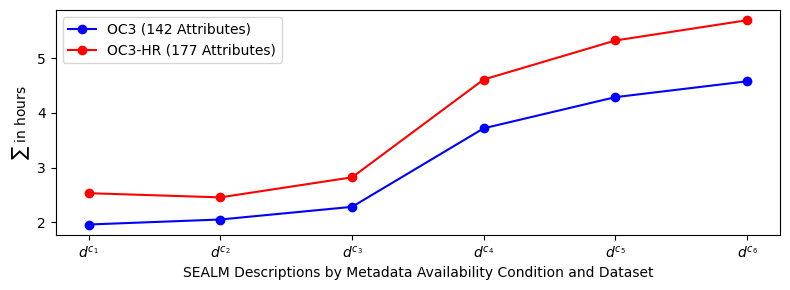

In [55]:
x_labels = [promt_dict_math[label] for label in OC3_time_sum.index]

# Create the plot
plt.figure(figsize=(8, 3))

# Plot each Series
plt.plot(x_labels, OC3_time_sum.values, marker='o', label='OC3 (142 Attributes)', color='b')
plt.plot(x_labels, OC3HR_time_sum.values, marker='o', label='OC3-HR (177 Attributes)', color='r')

# Add titles and labels
#plt.title('OC3 and OC3HR Time Series Plot')
plt.xlabel('SEALM Descriptions by Metadata Availability Condition and Dataset')
plt.ylabel('$\sum$ in hours')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


<>:15: SyntaxWarning: invalid escape sequence '\s'
<>:15: SyntaxWarning: invalid escape sequence '\s'
C:\Users\leona\AppData\Local\Temp\ipykernel_27348\373927013.py:15: SyntaxWarning: invalid escape sequence '\s'
  plt.ylabel('$\sum$ in hours')


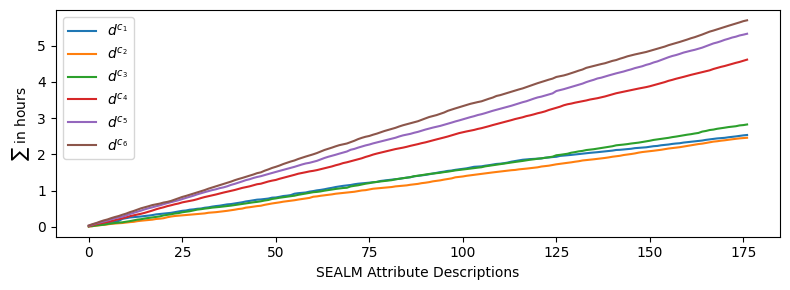

In [90]:
x_labels = [x+1 for x in range(len(df_graph_OC3HR))]

# Calculate the cumulative sum for each series
cumsum_df = (df_graph_OC3HR[["promt_v1_time","promt_v2_time","promt_v3_time","promt_v4_time","promt_v5_time","promt_v6_time"]]/3600).cumsum()

# Plot each series using cumulative sum
plt.figure(figsize=(8, 3))

for column in cumsum_df.columns:
    plt.plot(cumsum_df.index, cumsum_df[column], label=promt_dict_math[column])

# Add titles and labels
#plt.title('Cumulative Sum of OC3HR Time Series')
plt.xlabel('SEALM Attribute Descriptions')
plt.ylabel('$\sum$ in hours')
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

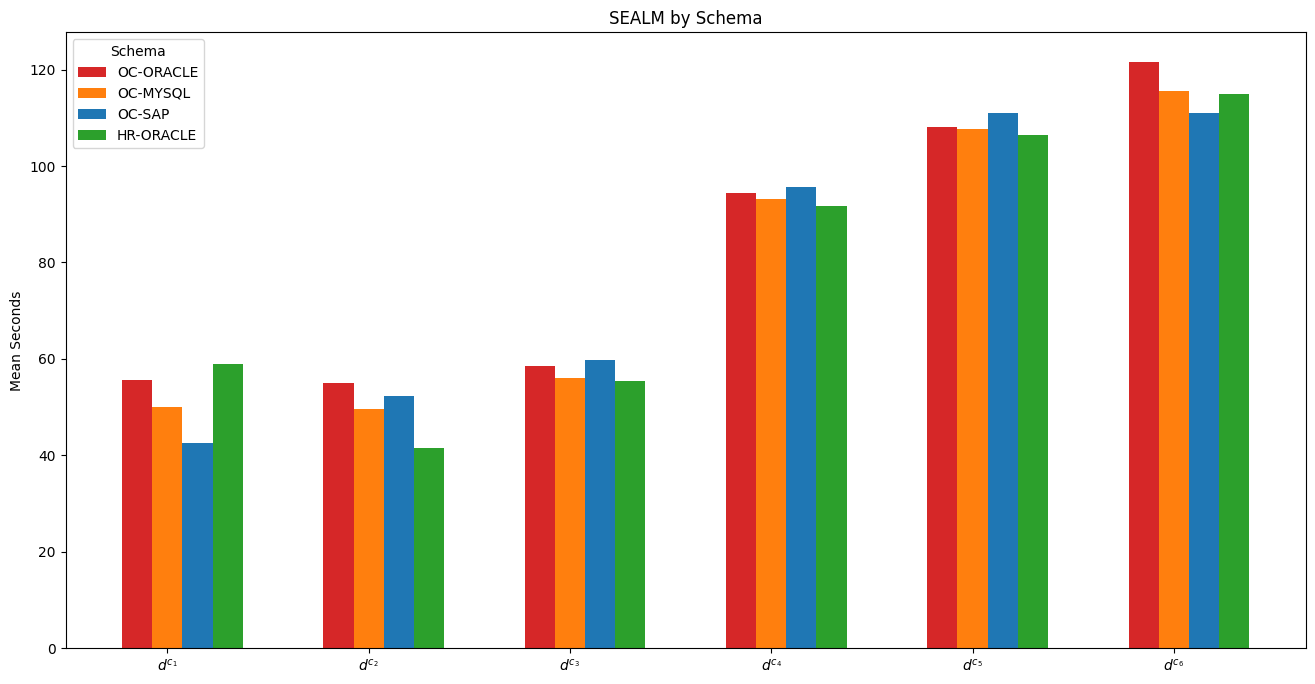

In [46]:
fig, ax = plt.subplots(figsize=(16, 8))
unique_methods = df_OC3HR_time.signature_method.unique()
schemas = df_OC3HR_time['schema'].unique()
# Create bars
for i, method in enumerate(unique_methods):
    for j, schema in enumerate(schemas):
        mean_seconds = df_OC3HR_time[(df_OC3HR_time['signature_method'] == method) & (df_OC3HR_time['schema'] == schema)]['mean_seconds']
        ax.bar(i + 0.15 * j, mean_seconds, width=0.15, label=schema if i == 0 else "", color=schema_dict_color[schema])
# Label formatting
ax.set_xticks([i + 0.15 for i in range(len(unique_methods))])
ax.set_xticklabels([promt_dict_math[method] for method in unique_methods])
ax.set_ylabel('Mean Seconds')
ax.set_title("SEALM by Schema")

# Adding the legend
ax.legend(title="Schema")

plt.show()

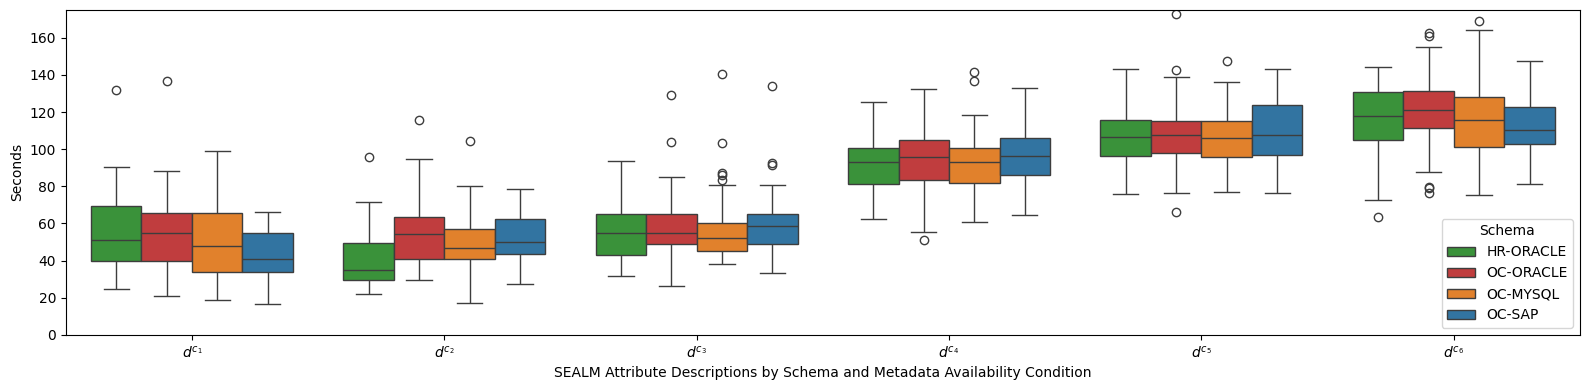

In [101]:
# Assuming df_graph_OC3HR has a 'schema' column and other columns as signature time measurements
# We'll melt only the columns related to time measurements to prepare for the boxplot
df_melted = df_graph_OC3HR.melt(id_vars=['schema'], value_vars=signatures_lm_time,
                                var_name='signature_method', value_name='seconds')

df_melted['signature_method'] = df_melted['signature_method'].map(promt_dict_math)

# Plotting
plt.figure(figsize=(16, 4))
ax = sns.boxplot(data=df_melted, x='signature_method', y='seconds', hue='schema', palette=schema_dict_color)

#Customize the plot
plt.xlabel("SEALM Attribute Descriptions by Schema and Metadata Availability Condition")
plt.ylabel("Seconds")
plt.legend(title="Schema")
# Set y-axis limit
ax.set_ylim(0, 175)
# Show plot
plt.tight_layout()  # This adjusts the plot to ensure everything fits without overlap
plt.show()

In [333]:
df_melted

,schema,signature_method,seconds
0,HR-ORACLE,$c_1$,46.510955
1,HR-ORACLE,$c_1$,131.862349
2,HR-ORACLE,$c_1$,61.399203
3,HR-ORACLE,$c_1$,41.709743
4,HR-ORACLE,$c_1$,55.460831
...,...,...,...
1057,OC-SAP,$c_6$,110.464357
1058,OC-SAP,$c_6$,103.196374
1059,OC-SAP,$c_6$,125.593873
1060,OC-SAP,$c_6$,122.488940


## Processing Time: Blocking

In [79]:
for signature_variant in signatures:
    st = time.time()
    _, blocked_linkages_id = lsh_matching_sequence(df_graph_OC3HR, 
                                                                    entities, 
                                                                    k=25,
                                                                    signature_variant=signature_variant)     
    et = time.time()
    print("Blocking " + signature_method_dict[signature_variant] + " elapsed time :" + str(et - st))

Blocking $a^{c_1}$ elapsed time :0.051932573318481445
Blocking $a^{c_2}$ elapsed time :0.030808448791503906
Blocking $a^{c_3}$ elapsed time :0.044846296310424805
Blocking $a^{c_4}$ elapsed time :0.03724360466003418
Blocking $a^{c_5}$ elapsed time :0.03343677520751953
Blocking $a^{c_6}$ elapsed time :0.03573298454284668
Blocking $d^{c_1}$ elapsed time :0.050323486328125
Blocking $d^{c_2}$ elapsed time :0.04590487480163574
Blocking $d^{c_3}$ elapsed time :0.03385353088378906
Blocking $d^{c_4}$ elapsed time :0.030355453491210938
Blocking $d^{c_5}$ elapsed time :0.0406186580657959
Blocking $d^{c_6}$ elapsed time :0.033008575439453125


## Processing Time: Filtering

In [82]:
for signature_variant in signatures:
    st = time.time()
    blocking_linkages_sim = []
    _, blocked_linkages_id = lsh_matching_sequence(df_graph_OC3HR,
                                                   entities, 
                                                   k=25,
                                                   signature_variant=signature_variant)
    for linkage in blocked_linkages_id:
      ce_a = getattr(get_entity_by_entity_id(entities, linkage[0]), signature_variant)
      ce_b = getattr(get_entity_by_entity_id(entities, linkage[1]), signature_variant)
      sim_cosine = util.cos_sim(ce_a, ce_b)
      blocking_linkages_sim.append((linkage[0], linkage[1], sim_cosine))

    # Step 1: Sort based on sim_cosine in descending order
    blocking_linkages_sim_sorted = sorted(blocking_linkages_sim, key=lambda x: x[2], reverse=True)
    
    # Step 2: Select the top k elements
    top_k_blocking_linkages_sim = blocking_linkages_sim_sorted[:1000]
    
    # Step 3: (Lk) Removing the sim_cosine element from each tuple in the top k results
    top_k_blocking_linkages = [(linkage[0], linkage[1]) for linkage in top_k_blocking_linkages_sim]  

    et = time.time()
    print("Filtering " + signature_method_dict[signature_variant] + " elapsed time :" + str(et - st))

Filtering $a^{c_1}$ elapsed time :0.37516307830810547
Filtering $a^{c_2}$ elapsed time :0.35129666328430176
Filtering $a^{c_3}$ elapsed time :0.35980892181396484
Filtering $a^{c_4}$ elapsed time :0.33792805671691895
Filtering $a^{c_5}$ elapsed time :0.3301870822906494
Filtering $a^{c_6}$ elapsed time :0.3497283458709717
Filtering $d^{c_1}$ elapsed time :0.35210680961608887
Filtering $d^{c_2}$ elapsed time :0.3608670234680176
Filtering $d^{c_3}$ elapsed time :0.43433141708374023
Filtering $d^{c_4}$ elapsed time :0.5957305431365967
Filtering $d^{c_5}$ elapsed time :0.33832383155822754
Filtering $d^{c_6}$ elapsed time :0.3403308391571045


In [89]:
for signature_variant in signatures:
    st = time.time()
    blocking_linkages_sim = []
    _, blocked_linkages_id = lsh_matching_sequence(df_graph_OC3HR,
                                                   entities, 
                                                   k=50,
                                                   signature_variant=signature_variant)
    for linkage in blocked_linkages_id:
      ce_a = getattr(get_entity_by_entity_id(entities, linkage[0]), signature_variant)
      ce_b = getattr(get_entity_by_entity_id(entities, linkage[1]), signature_variant)
      sim_cosine = util.cos_sim(ce_a, ce_b)
      blocking_linkages_sim.append((linkage[0], linkage[1], sim_cosine))

    # Step 1: Sort based on sim_cosine in descending order
    blocking_linkages_sim_sorted = sorted(blocking_linkages_sim, key=lambda x: x[2], reverse=True)
    
    # Step 2: Select the top k elements
    top_k_blocking_linkages_sim = blocking_linkages_sim_sorted[:1000]
    
    # Step 3: (Lk) Removing the sim_cosine element from each tuple in the top k results
    top_k_blocking_linkages = [(linkage[0], linkage[1]) for linkage in top_k_blocking_linkages_sim]  

    et = time.time()
    print("Filtering " + signature_method_dict[signature_variant] + " elapsed time :" + str(et - st))

Filtering $a^{c_1}$ elapsed time :0.8448796272277832
Filtering $a^{c_2}$ elapsed time :0.6718859672546387
Filtering $a^{c_3}$ elapsed time :0.6891732215881348
Filtering $a^{c_4}$ elapsed time :0.7098698616027832
Filtering $a^{c_5}$ elapsed time :0.6291401386260986
Filtering $a^{c_6}$ elapsed time :0.6022739410400391
Filtering $d^{c_1}$ elapsed time :0.6293604373931885
Filtering $d^{c_2}$ elapsed time :0.5999047756195068
Filtering $d^{c_3}$ elapsed time :0.6687614917755127
Filtering $d^{c_4}$ elapsed time :0.6415228843688965
Filtering $d^{c_5}$ elapsed time :0.6642577648162842
Filtering $d^{c_6}$ elapsed time :0.6614718437194824


In [90]:
for signature_variant in signatures:
    st = time.time()
    blocking_linkages_sim = []
    _, blocked_linkages_id = lsh_matching_sequence(df_graph_OC3HR,
                                                   entities, 
                                                   k=100,
                                                   signature_variant=signature_variant)
    for linkage in blocked_linkages_id:
      ce_a = getattr(get_entity_by_entity_id(entities, linkage[0]), signature_variant)
      ce_b = getattr(get_entity_by_entity_id(entities, linkage[1]), signature_variant)
      sim_cosine = util.cos_sim(ce_a, ce_b)
      blocking_linkages_sim.append((linkage[0], linkage[1], sim_cosine))

    # Step 1: Sort based on sim_cosine in descending order
    blocking_linkages_sim_sorted = sorted(blocking_linkages_sim, key=lambda x: x[2], reverse=True)
    
    # Step 2: Select the top k elements
    top_k_blocking_linkages_sim = blocking_linkages_sim_sorted[:1000]
    
    # Step 3: (Lk) Removing the sim_cosine element from each tuple in the top k results
    top_k_blocking_linkages = [(linkage[0], linkage[1]) for linkage in top_k_blocking_linkages_sim]  

    et = time.time()
    print("Filtering " + signature_method_dict[signature_variant] + " elapsed time :" + str(et - st))

Filtering $a^{c_1}$ elapsed time :1.3402116298675537
Filtering $a^{c_2}$ elapsed time :1.0687661170959473
Filtering $a^{c_3}$ elapsed time :1.4300768375396729
Filtering $a^{c_4}$ elapsed time :1.0115599632263184
Filtering $a^{c_5}$ elapsed time :0.9599659442901611
Filtering $a^{c_6}$ elapsed time :0.9681086540222168
Filtering $d^{c_1}$ elapsed time :0.9793553352355957
Filtering $d^{c_2}$ elapsed time :0.9826114177703857
Filtering $d^{c_3}$ elapsed time :0.9304904937744141
Filtering $d^{c_4}$ elapsed time :0.9591948986053467
Filtering $d^{c_5}$ elapsed time :0.980370044708252
Filtering $d^{c_6}$ elapsed time :0.9722423553466797


## OC3 Blocking

In [ ]:
performance_plot_lsh(df_graph_OC3,
                     entities,
                     set_OC3_gt,
                     signature_variant="promt_v6_normalized")

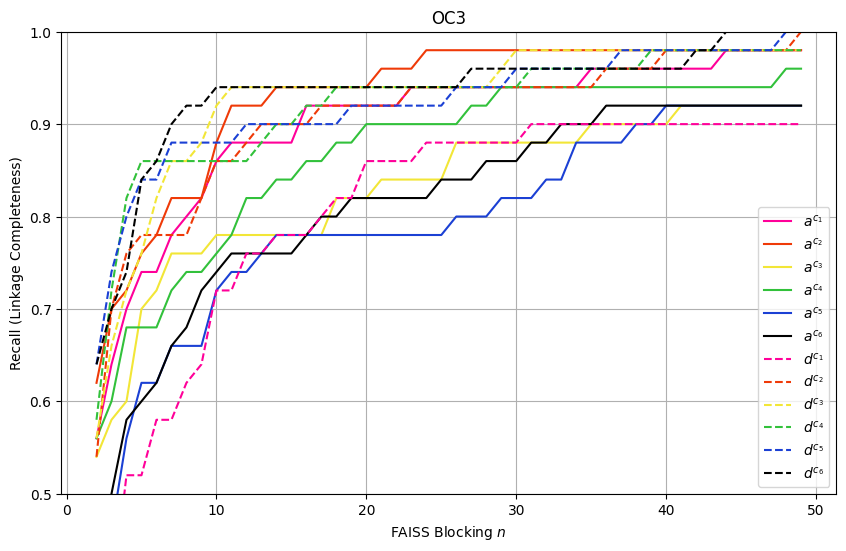

,Setting,AUC_PC,AUC_PQ
0,v1_normalized,42.51,1.287329
1,v2_normalized,43.82,1.340970
2,v3_normalized,39.19,1.182436
3,v4_normalized,40.90,1.223045
4,v5_normalized,37.38,1.085366
5,v6_normalized,38.39,1.112039
6,promt_v1_normalized,38.00,1.055172
7,promt_v2_normalized,42.77,1.309400
8,promt_v3_normalized,43.75,1.337834
9,promt_v4_normalized,43.42,1.355117


In [69]:
performances_plot_lsh(df_graph_OC3,
                      entities,
                      set_OC3_gt,
                      title="OC3",
                      signature_variants=signatures)

## OC3 Filtering top-k

In [ ]:
pr_lsh(df_graph_OC3, entities, set_OC3_gt, fixed_blocking_k=50, signature_variant="v2_normalized", max_top_k=1000)

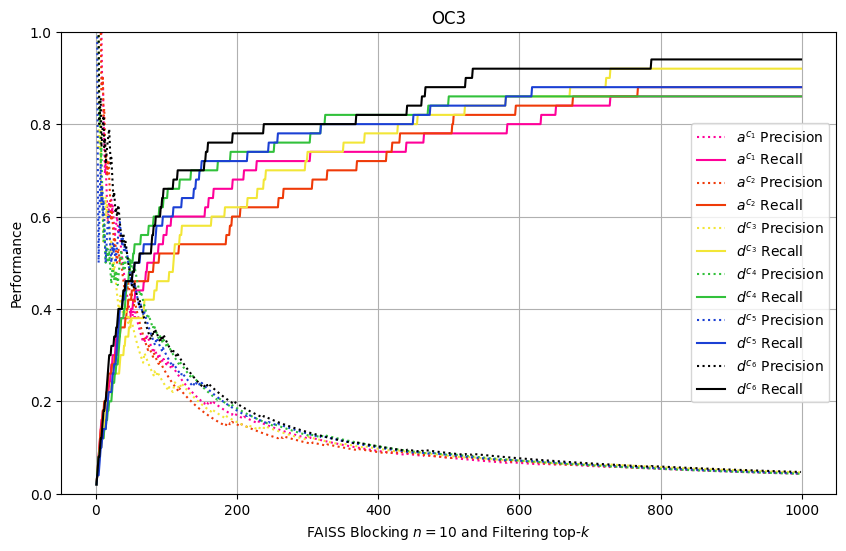

In [42]:
pr_plot_lsh(df_graph_OC3,
            entities,
            set_OC3_gt,
            title="OC3",
            fixed_blocking_k=10,
            signature_variants=signatures_best2,
            max_top_k=1000)

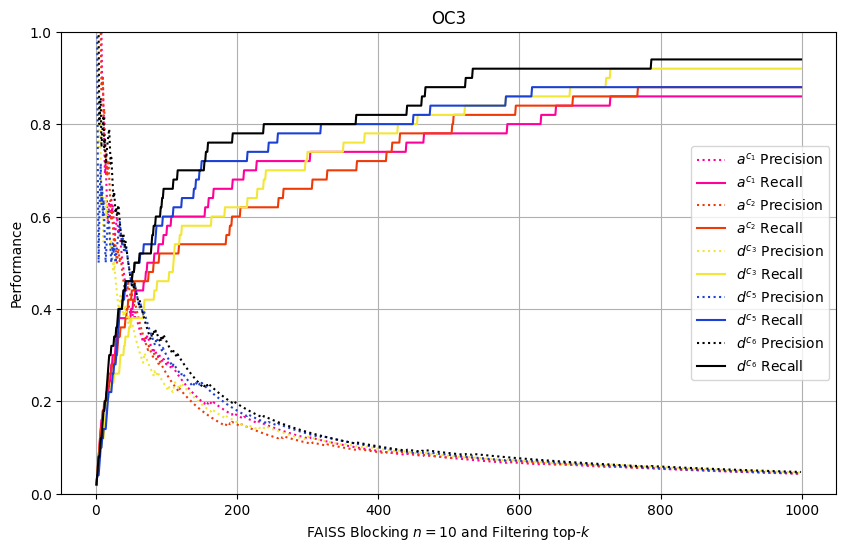

In [76]:
pr_plot_lsh(df_graph_OC3,
            entities,
            set_OC3_gt,
            title="OC3",
            fixed_blocking_k=10,
            signature_variants=signatures_best,
            max_top_k=1000)

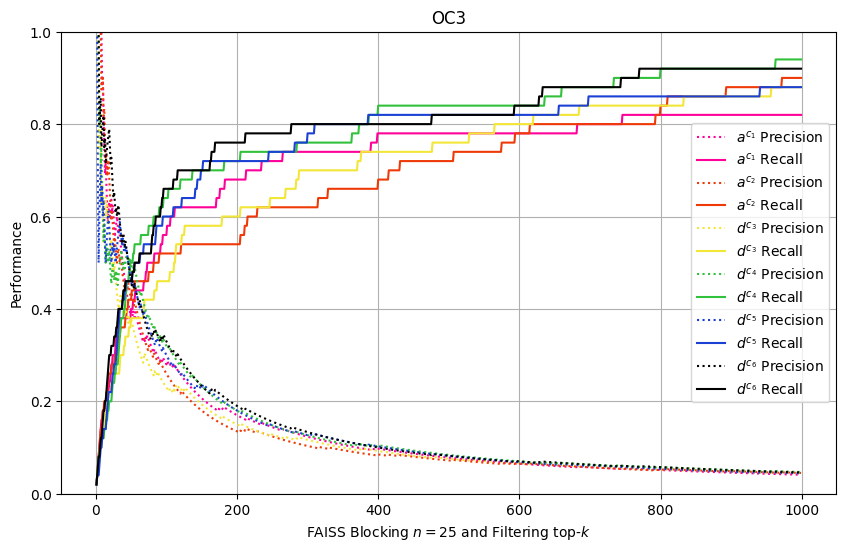

In [44]:
pr_plot_lsh(df_graph_OC3,
            entities,
            set_OC3_gt,
            title="OC3",
            fixed_blocking_k=25,
            signature_variants=signatures_best2,
            max_top_k=1000)

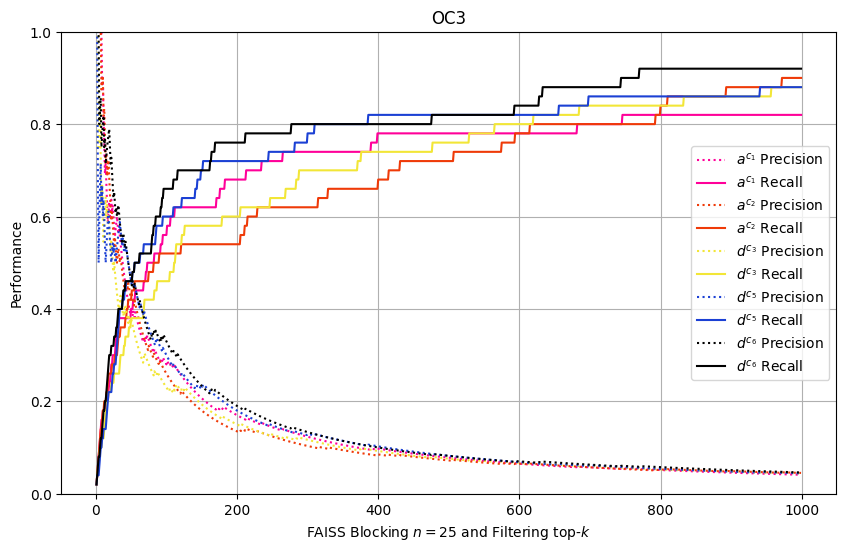

In [77]:
pr_plot_lsh(df_graph_OC3,
            entities,
            set_OC3_gt,
            title="OC3",
            fixed_blocking_k=25,
            signature_variants=signatures_best,
            max_top_k=1000)

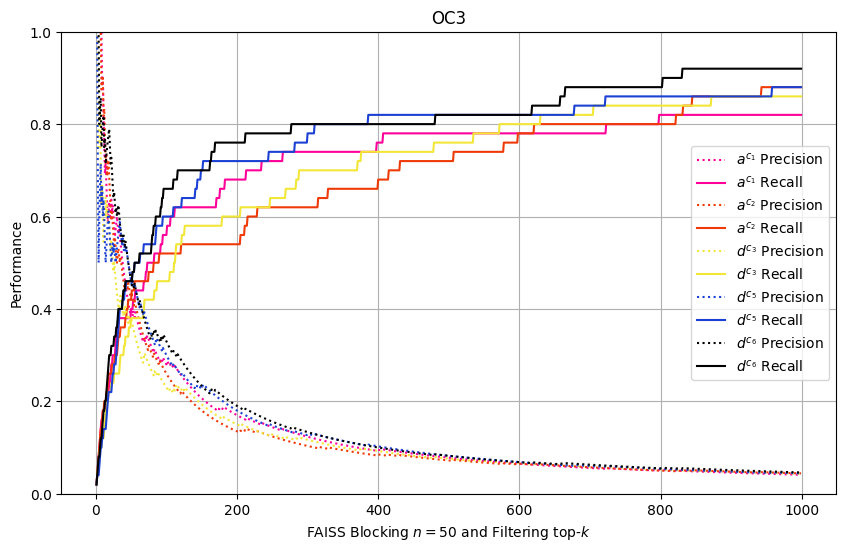

In [78]:
pr_plot_lsh(df_graph_OC3,
            entities,
            set_OC3_gt,
            title="OC3",
            fixed_blocking_k=50,
            signature_variants=signatures_best,
            max_top_k=1000)

## OC3HR Blocking

In [ ]:
performance_plot_lsh(df_graph_OC3HR,
                     entities,
                     set_OC3HR_gt,
                     signature_variant="promt_v6_normalized")

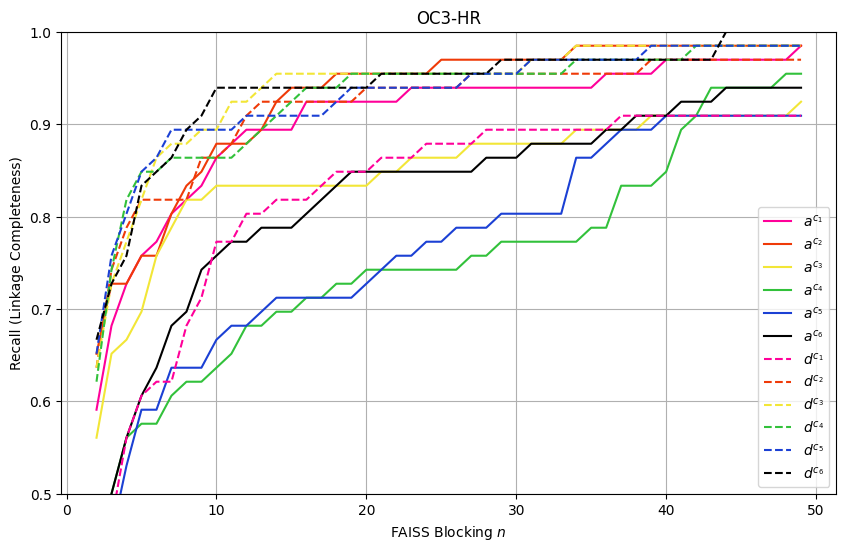

,Setting,AUC_PC,AUC_PQ
0,v1_normalized,42.727273,1.244705
1,v2_normalized,43.727273,1.275498
2,v3_normalized,39.969697,1.171125
3,v4_normalized,35.416667,0.981422
4,v5_normalized,36.128788,0.988569
5,v6_normalized,38.825758,1.067967
6,promt_v1_normalized,38.969697,1.063048
7,promt_v2_normalized,43.318182,1.284934
8,promt_v3_normalized,44.234848,1.309685
9,promt_v4_normalized,43.772727,1.300500


In [70]:
performances_plot_lsh(df_graph_OC3HR,
                      entities,
                      set_OC3HR_gt,
                      title="OC3-HR",
                      signature_variants=signatures)

## OC3HR Filtering top-k

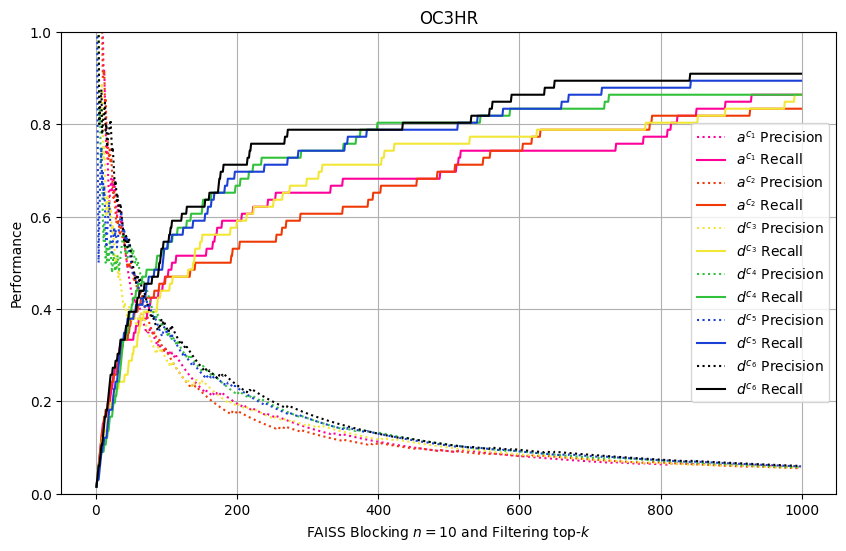

In [43]:
pr_plot_lsh(df_graph_OC3HR,
            entities,
            set_OC3HR_gt,
            title="OC3HR",
            fixed_blocking_k=10,
            signature_variants=signatures_best2,
            max_top_k=1000)

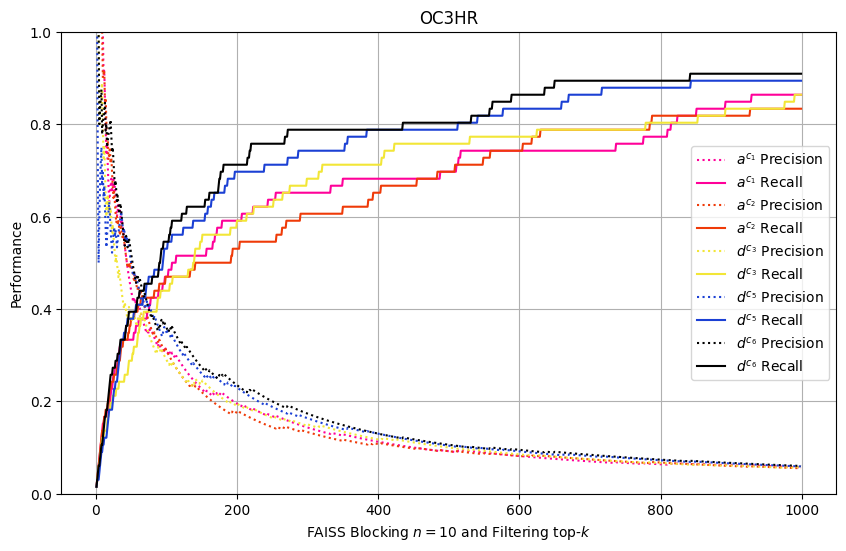

In [79]:
pr_plot_lsh(df_graph_OC3HR,
            entities,
            set_OC3HR_gt,
            title="OC3HR",
            fixed_blocking_k=10,
            signature_variants=signatures_best,
            max_top_k=1000)

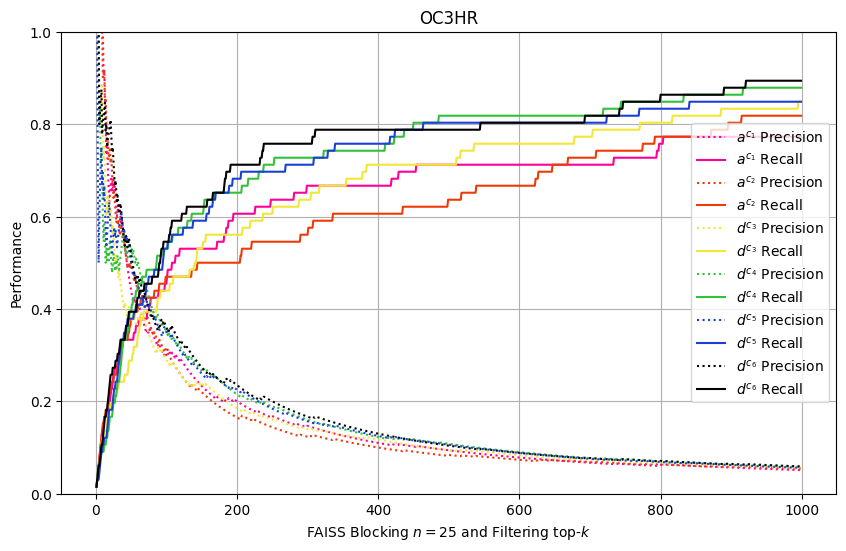

In [45]:
pr_plot_lsh(df_graph_OC3HR,
            entities,
            set_OC3HR_gt,
            title="OC3HR",
            fixed_blocking_k=25,
            signature_variants=signatures_best2,
            max_top_k=1000)

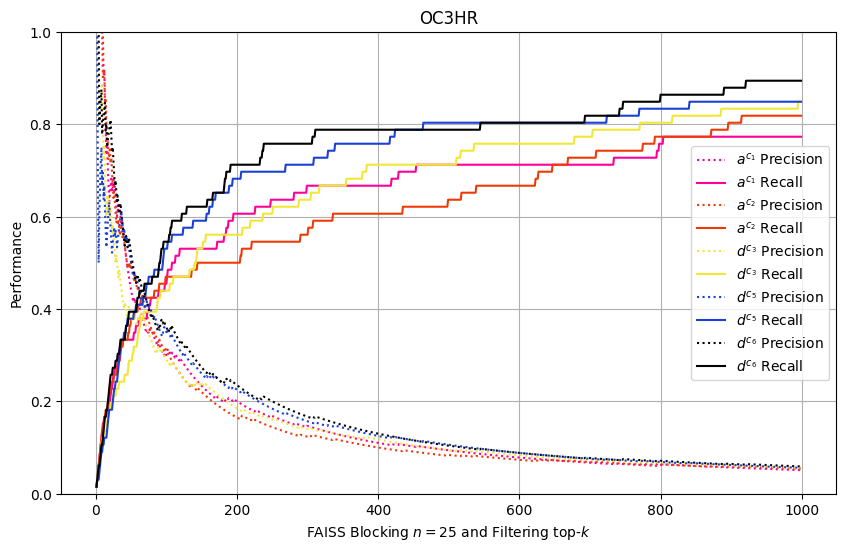

In [80]:
pr_plot_lsh(df_graph_OC3HR,
            entities,
            set_OC3HR_gt,
            title="OC3HR",
            fixed_blocking_k=25,
            signature_variants=signatures_best,
            max_top_k=1000)

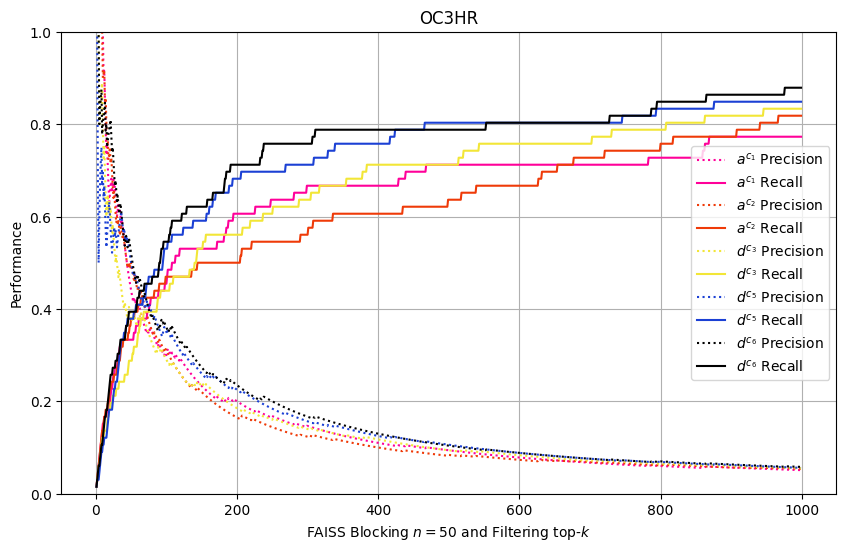

In [81]:
pr_plot_lsh(df_graph_OC3HR,
            entities,
            set_OC3HR_gt,
            title="OC3HR",
            fixed_blocking_k=50,
            signature_variants=signatures_best,
            max_top_k=1000)

## Problem Analysis (not all linkages are found)

In [63]:
signature="v2_normalized"
n=50
k=1000
blocking_linkages_sim = []
#blocking
potential_linkages, potential_linkages_id = lsh_matching_sequence(df_graph_OC3HRFA, 
                                                                  entities, 
                                                                  k=n,
                                                                  signature_variant=signature)
#filtering
for linkage in potential_linkages_id:
    ce_a = getattr(get_entity_by_entity_id(entities, linkage[0]), signature)
    ce_b = getattr(get_entity_by_entity_id(entities, linkage[1]), signature)
    sim_cosine = util.cos_sim(ce_a, ce_b)
    blocking_linkages_sim.append((linkage[0], linkage[1], sim_cosine))
    
# Step 1: Sort based on sim_cosine in descending order
blocking_linkages_sim_sorted = sorted(blocking_linkages_sim, key=lambda x: x[2], reverse=True)
    
# Step 2: Select the top k elements
top_k_blocking_linkages_sim = blocking_linkages_sim_sorted[:k]
    
# Step 3: (Lk) Removing the sim_cosine element from each tuple in the top k results
top_k_blocking_linkages = [(linkage[0], linkage[1]) for linkage in top_k_blocking_linkages_sim]

#evaluation
# look into linkages that were not found
set_OC3HR_gt_left = set_OC3HR_gt.copy()

for i, linkage in enumerate(set_OC3HR_gt):
    if linkage in top_k_blocking_linkages:
        set_OC3HR_gt_left.remove(linkage)

#results
print(len(set_OC3HR_gt_left))
set_OC3HR_gt_left

for linkage in set_OC3HR_gt_left:
    print(df_graph_OC3HR[df_graph_OC3HR.id == linkage[0]].name.values[0], " <-> ", df_graph_OC3HR[df_graph_OC3HR.id == linkage[1]].name.values[0])

15
DELIVERY_ADDRESS  <->  city
DELIVERY_ADDRESS  <->  state
DELIVERY_ADDRESS  <->  postalCode
DELIVERY_ADDRESS  <->  country
PRODUCT_DETAILS  <->  productDescription
PRODUCT_DETAILS  <->  PRODUCTDESCRIPTION
PRODUCT_INVENTORY  <->  quantityInStock
PRODUCT_INVENTORY  <->  CAPACITY
quantityInStock  <->  CAPACITY
orderLineNumber  <->  LINEID
PRODUCT_ID  <->  productCode
UNIT_PRICE  <->  UNITCOST
priceEach  <->  UNITCOST
reportsTo  <->  MANAGER_ID
territory  <->  REGION_NAME


In [62]:
signature="promt_v6_normalized"
n=50
k=1000
blocking_linkages_sim = []
#blocking
potential_linkages, potential_linkages_id = lsh_matching_sequence(df_graph_OC3HRFA, 
                                                                  entities, 
                                                                  k=n,
                                                                  signature_variant=signature)
#filtering
for linkage in potential_linkages_id:
    ce_a = getattr(get_entity_by_entity_id(entities, linkage[0]), signature)
    ce_b = getattr(get_entity_by_entity_id(entities, linkage[1]), signature)
    sim_cosine = util.cos_sim(ce_a, ce_b)
    blocking_linkages_sim.append((linkage[0], linkage[1], sim_cosine))
    
# Step 1: Sort based on sim_cosine in descending order
blocking_linkages_sim_sorted = sorted(blocking_linkages_sim, key=lambda x: x[2], reverse=True)
    
# Step 2: Select the top k elements
top_k_blocking_linkages_sim = blocking_linkages_sim_sorted[:k]
    
# Step 3: (Lk) Removing the sim_cosine element from each tuple in the top k results
top_k_blocking_linkages = [(linkage[0], linkage[1]) for linkage in top_k_blocking_linkages_sim]

#evaluation
# look into linkages that were not found
set_OC3HR_gt_left = set_OC3HR_gt.copy()

for i, linkage in enumerate(set_OC3HR_gt):
    if linkage in top_k_blocking_linkages:
        set_OC3HR_gt_left.remove(linkage)

#results
print(len(set_OC3HR_gt_left))
set_OC3HR_gt_left

for linkage in set_OC3HR_gt_left:
    print(df_graph_OC3HR[df_graph_OC3HR.id == linkage[0]].name.values[0], " <-> ", df_graph_OC3HR[df_graph_OC3HR.id == linkage[1]].name.values[0])

9
DELIVERY_ADDRESS  <->  state
DELIVERY_ADDRESS  <->  country
PRODUCT_INVENTORY  <->  CAPACITY
quantityInStock  <->  CAPACITY
UNIT_PRICE  <->  priceEach
priceEach  <->  UNITCOST
reportsTo  <->  MANAGER_ID
officeCode  <->  DEPARTMENT_ID
territory  <->  REGION_NAME
